In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# !pip install accelerate
# !pip install diffusers
# !pip install datasets


In [1]:
import os
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.optim import AdamW
from diffusers import UNet2DModel, DDPMScheduler, DDPMPipeline
from diffusers.optimization import get_cosine_schedule_with_warmup
from datasets import load_dataset
from accelerate import Accelerator
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import random
import timeit

In [2]:
RANDOM_SEED = 42
IMG_SIZE = 128
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
NUM_EPOCHS = 512
NUM_GENERATE_IMAGES = 9
NUM_TIMESTEPS = 2000
MIXED_PRECISION = "fp16"
GRADIENT_ACCUMULATION_STEPS = 1

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
device

'cuda'

Resolving data files:   0%|          | 0/100 [00:00<?, ?it/s]

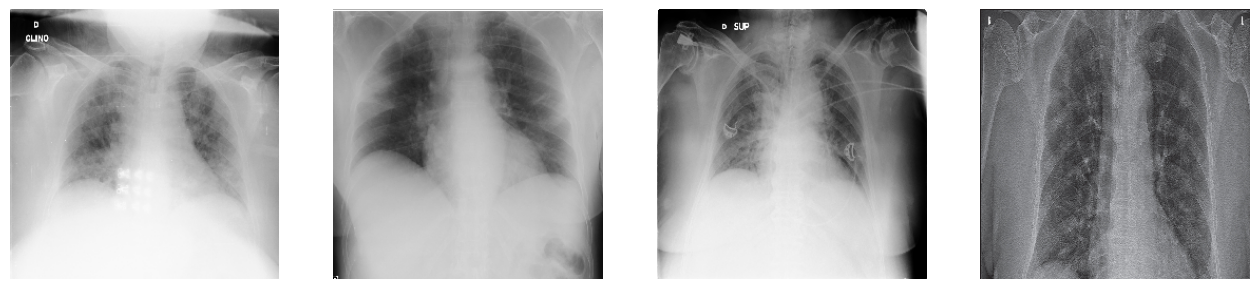

In [5]:
path = "/content/drive/MyDrive/4. BGSU/1.2 PhD_Courses/3. 7200_Machin Learning/Final_project/CS7200_SP2024_Project_G01/Notebooks/DDPM-Pytorch"
dataset = load_dataset(f"{path}/chest_X_ray_data", split="train", trust_remote_code=True)

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4]["image"]):
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

In [6]:

preprocess = transforms.Compose(
[
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)


train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)


In [7]:
model = UNet2DModel(
    sample_size=IMG_SIZE,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(128, 128, 256, 256, 512, 512),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D"
    ),
    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D"
    )
)
model = model.to(device)

In [8]:
sample_image = dataset[0]["images"].unsqueeze(0).to(device)
print("Input shape", sample_image.shape)
print("Output shape", model(sample_image, timestep=0).sample.shape)

Input shape torch.Size([1, 3, 128, 128])
Output shape torch.Size([1, 3, 128, 128])


In [9]:
noise_scheduler = DDPMScheduler(num_train_timesteps=NUM_TIMESTEPS)
noise = torch.randn(sample_image.shape).to(device)
timesteps = torch.LongTensor([50]).to(device)
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

In [10]:
noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)
print(loss)

tensor(1.1990, device='cuda:0', grad_fn=<MseLossBackward0>)


In [11]:
def sample_image_generation(model, noise_scheduler, num_generate_images, random_seed, num_timesteps):
    pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

    images = pipeline(
        batch_size=num_generate_images,
        generator=torch.manual_seed(random_seed),
        num_inference_steps=num_timesteps
    ).images

    fig = plt.figure()
    for i in range(1, num_generate_images+1):
        fig.add_subplot(3, 3, i)
        plt.imshow(images[i-1])
    plt.show()

In [18]:
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=len(train_dataloader)*NUM_EPOCHS
)

accelerator = Accelerator(
    mixed_precision=MIXED_PRECISION,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS
)

model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(model, optimizer, train_dataloader, lr_scheduler)

start = timeit.default_timer()
for epoch in tqdm(range(NUM_EPOCHS), position=0, leave=True):
    model.train()
    train_running_loss = 0
    for idx, batch in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        clean_images = batch["images"].to(device)
        noise = torch.randn(clean_images.shape).to(device)
        last_batch_size = len(clean_images)

        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (last_batch_size,)).to(device)
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        with accelerator.accumulate(model):
            noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
            loss = F.mse_loss(noise_pred, noise)
            accelerator.backward(loss)

            accelerator.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

        train_running_loss += loss.item()
    train_loss = train_running_loss / (idx+1)

    train_learning_rate = lr_scheduler.get_last_lr()[0]
    print("-"*30)
    print(f"Train Loss EPOCH: {epoch+1}: {train_loss:.4f}")
    print(f"Train Learning Rate EPOCH: {epoch+1}: {train_learning_rate}")
    # if epoch%10 == 0:
    #     sample_image_generation(model, noise_scheduler, NUM_GENERATE_IMAGES, RANDOM_SEED, NUM_TIMESTEPS)
    print("-"*30)

stop = timeit.default_timer()
print(f"Training Time: {stop-start:.2f}s")

  0%|          | 1/512 [00:08<1:11:26,  8.39s/it]

------------------------------
Train Loss EPOCH: 1: 1.1203
Train Learning Rate EPOCH: 1: 1.4000000000000001e-06
------------------------------


  0%|          | 2/512 [00:13<54:34,  6.42s/it]  

------------------------------
Train Loss EPOCH: 2: 1.0915
Train Learning Rate EPOCH: 2: 2.8000000000000003e-06
------------------------------


  1%|          | 3/512 [00:18<48:57,  5.77s/it]

------------------------------
Train Loss EPOCH: 3: 1.0345
Train Learning Rate EPOCH: 3: 4.2000000000000004e-06
------------------------------


  1%|          | 4/512 [00:23<47:03,  5.56s/it]

------------------------------
Train Loss EPOCH: 4: 0.9520
Train Learning Rate EPOCH: 4: 5.600000000000001e-06
------------------------------


  1%|          | 5/512 [00:28<45:14,  5.35s/it]

------------------------------
Train Loss EPOCH: 5: 0.8526
Train Learning Rate EPOCH: 5: 7.000000000000001e-06
------------------------------


  1%|          | 6/512 [00:33<44:17,  5.25s/it]

------------------------------
Train Loss EPOCH: 6: 0.7391
Train Learning Rate EPOCH: 6: 8.400000000000001e-06
------------------------------


  1%|▏         | 7/512 [00:39<44:21,  5.27s/it]

------------------------------
Train Loss EPOCH: 7: 0.6096
Train Learning Rate EPOCH: 7: 9.800000000000001e-06
------------------------------


  2%|▏         | 8/512 [00:44<44:01,  5.24s/it]

------------------------------
Train Loss EPOCH: 8: 0.4898
Train Learning Rate EPOCH: 8: 1.1200000000000001e-05
------------------------------


  2%|▏         | 9/512 [00:49<43:50,  5.23s/it]

------------------------------
Train Loss EPOCH: 9: 0.3912
Train Learning Rate EPOCH: 9: 1.2600000000000001e-05
------------------------------


  2%|▏         | 10/512 [00:54<43:52,  5.24s/it]

------------------------------
Train Loss EPOCH: 10: 0.2754
Train Learning Rate EPOCH: 10: 1.4000000000000001e-05
------------------------------


  2%|▏         | 11/512 [01:00<44:15,  5.30s/it]

------------------------------
Train Loss EPOCH: 11: 0.2155
Train Learning Rate EPOCH: 11: 1.54e-05
------------------------------


  2%|▏         | 12/512 [01:05<44:03,  5.29s/it]

------------------------------
Train Loss EPOCH: 12: 0.1245
Train Learning Rate EPOCH: 12: 1.6800000000000002e-05
------------------------------


  3%|▎         | 13/512 [01:10<44:07,  5.31s/it]

------------------------------
Train Loss EPOCH: 13: 0.1076
Train Learning Rate EPOCH: 13: 1.8200000000000002e-05
------------------------------


  3%|▎         | 14/512 [01:16<44:34,  5.37s/it]

------------------------------
Train Loss EPOCH: 14: 0.0726
Train Learning Rate EPOCH: 14: 1.9600000000000002e-05
------------------------------


  3%|▎         | 15/512 [01:21<44:30,  5.37s/it]

------------------------------
Train Loss EPOCH: 15: 0.0839
Train Learning Rate EPOCH: 15: 2.1e-05
------------------------------


  3%|▎         | 16/512 [01:26<44:26,  5.38s/it]

------------------------------
Train Loss EPOCH: 16: 0.0787
Train Learning Rate EPOCH: 16: 2.2400000000000002e-05
------------------------------


  3%|▎         | 17/512 [01:32<45:00,  5.46s/it]

------------------------------
Train Loss EPOCH: 17: 0.0796
Train Learning Rate EPOCH: 17: 2.38e-05
------------------------------


  4%|▎         | 18/512 [01:38<45:04,  5.47s/it]

------------------------------
Train Loss EPOCH: 18: 0.0618
Train Learning Rate EPOCH: 18: 2.5200000000000003e-05
------------------------------


  4%|▎         | 19/512 [01:43<45:01,  5.48s/it]

------------------------------
Train Loss EPOCH: 19: 0.0542
Train Learning Rate EPOCH: 19: 2.6600000000000003e-05
------------------------------


  4%|▍         | 20/512 [01:49<44:53,  5.48s/it]

------------------------------
Train Loss EPOCH: 20: 0.0633
Train Learning Rate EPOCH: 20: 2.8000000000000003e-05
------------------------------


  4%|▍         | 21/512 [01:54<44:29,  5.44s/it]

------------------------------
Train Loss EPOCH: 21: 0.0539
Train Learning Rate EPOCH: 21: 2.94e-05
------------------------------


  4%|▍         | 22/512 [01:59<44:17,  5.42s/it]

------------------------------
Train Loss EPOCH: 22: 0.0485
Train Learning Rate EPOCH: 22: 3.08e-05
------------------------------


  4%|▍         | 23/512 [02:05<43:43,  5.36s/it]

------------------------------
Train Loss EPOCH: 23: 0.0554
Train Learning Rate EPOCH: 23: 3.2200000000000003e-05
------------------------------


  5%|▍         | 24/512 [02:10<43:36,  5.36s/it]

------------------------------
Train Loss EPOCH: 24: 0.0489
Train Learning Rate EPOCH: 24: 3.3600000000000004e-05
------------------------------


  5%|▍         | 25/512 [02:15<43:23,  5.35s/it]

------------------------------
Train Loss EPOCH: 25: 0.0483
Train Learning Rate EPOCH: 25: 3.5e-05
------------------------------


  5%|▌         | 26/512 [02:21<43:10,  5.33s/it]

------------------------------
Train Loss EPOCH: 26: 0.0378
Train Learning Rate EPOCH: 26: 3.6400000000000004e-05
------------------------------


  5%|▌         | 27/512 [02:26<43:30,  5.38s/it]

------------------------------
Train Loss EPOCH: 27: 0.0435
Train Learning Rate EPOCH: 27: 3.7800000000000004e-05
------------------------------


  5%|▌         | 28/512 [02:31<43:14,  5.36s/it]

------------------------------
Train Loss EPOCH: 28: 0.0445
Train Learning Rate EPOCH: 28: 3.9200000000000004e-05
------------------------------


  6%|▌         | 29/512 [02:37<43:01,  5.34s/it]

------------------------------
Train Loss EPOCH: 29: 0.0415
Train Learning Rate EPOCH: 29: 4.0600000000000004e-05
------------------------------


  6%|▌         | 30/512 [02:43<45:38,  5.68s/it]

------------------------------
Train Loss EPOCH: 30: 0.0455
Train Learning Rate EPOCH: 30: 4.2e-05
------------------------------


  6%|▌         | 31/512 [02:48<44:48,  5.59s/it]

------------------------------
Train Loss EPOCH: 31: 0.0292
Train Learning Rate EPOCH: 31: 4.3400000000000005e-05
------------------------------


  6%|▋         | 32/512 [02:54<44:17,  5.54s/it]

------------------------------
Train Loss EPOCH: 32: 0.0259
Train Learning Rate EPOCH: 32: 4.4800000000000005e-05
------------------------------


  6%|▋         | 33/512 [02:59<43:40,  5.47s/it]

------------------------------
Train Loss EPOCH: 33: 0.0332
Train Learning Rate EPOCH: 33: 4.6200000000000005e-05
------------------------------


  7%|▋         | 34/512 [03:05<43:47,  5.50s/it]

------------------------------
Train Loss EPOCH: 34: 0.0377
Train Learning Rate EPOCH: 34: 4.76e-05
------------------------------


  7%|▋         | 35/512 [03:10<43:30,  5.47s/it]

------------------------------
Train Loss EPOCH: 35: 0.0285
Train Learning Rate EPOCH: 35: 4.9e-05
------------------------------


  7%|▋         | 36/512 [03:16<43:05,  5.43s/it]

------------------------------
Train Loss EPOCH: 36: 0.0311
Train Learning Rate EPOCH: 36: 5.0400000000000005e-05
------------------------------


  7%|▋         | 37/512 [03:21<43:12,  5.46s/it]

------------------------------
Train Loss EPOCH: 37: 0.0313
Train Learning Rate EPOCH: 37: 5.1800000000000005e-05
------------------------------


  7%|▋         | 38/512 [03:26<42:52,  5.43s/it]

------------------------------
Train Loss EPOCH: 38: 0.0309
Train Learning Rate EPOCH: 38: 5.3200000000000006e-05
------------------------------


  8%|▊         | 39/512 [03:32<42:27,  5.39s/it]

------------------------------
Train Loss EPOCH: 39: 0.0264
Train Learning Rate EPOCH: 39: 5.4600000000000006e-05
------------------------------


  8%|▊         | 40/512 [03:37<42:26,  5.39s/it]

------------------------------
Train Loss EPOCH: 40: 0.0265
Train Learning Rate EPOCH: 40: 5.6000000000000006e-05
------------------------------


  8%|▊         | 41/512 [03:42<42:09,  5.37s/it]

------------------------------
Train Loss EPOCH: 41: 0.0230
Train Learning Rate EPOCH: 41: 5.74e-05
------------------------------


  8%|▊         | 42/512 [03:48<41:58,  5.36s/it]

------------------------------
Train Loss EPOCH: 42: 0.0222
Train Learning Rate EPOCH: 42: 5.88e-05
------------------------------


  8%|▊         | 43/512 [03:53<41:34,  5.32s/it]

------------------------------
Train Loss EPOCH: 43: 0.0320
Train Learning Rate EPOCH: 43: 6.02e-05
------------------------------


  9%|▊         | 44/512 [03:58<41:39,  5.34s/it]

------------------------------
Train Loss EPOCH: 44: 0.0243
Train Learning Rate EPOCH: 44: 6.16e-05
------------------------------


  9%|▉         | 45/512 [04:04<41:35,  5.34s/it]

------------------------------
Train Loss EPOCH: 45: 0.0242
Train Learning Rate EPOCH: 45: 6.3e-05
------------------------------


  9%|▉         | 46/512 [04:09<41:21,  5.32s/it]

------------------------------
Train Loss EPOCH: 46: 0.0315
Train Learning Rate EPOCH: 46: 6.440000000000001e-05
------------------------------


  9%|▉         | 47/512 [04:15<41:44,  5.39s/it]

------------------------------
Train Loss EPOCH: 47: 0.0235
Train Learning Rate EPOCH: 47: 6.58e-05
------------------------------


  9%|▉         | 48/512 [04:20<41:41,  5.39s/it]

------------------------------
Train Loss EPOCH: 48: 0.0233
Train Learning Rate EPOCH: 48: 6.720000000000001e-05
------------------------------


 10%|▉         | 49/512 [04:25<41:29,  5.38s/it]

------------------------------
Train Loss EPOCH: 49: 0.0198
Train Learning Rate EPOCH: 49: 6.860000000000001e-05
------------------------------


 10%|▉         | 50/512 [04:31<41:30,  5.39s/it]

------------------------------
Train Loss EPOCH: 50: 0.0181
Train Learning Rate EPOCH: 50: 7e-05
------------------------------


 10%|▉         | 51/512 [04:36<41:26,  5.39s/it]

------------------------------
Train Loss EPOCH: 51: 0.0209
Train Learning Rate EPOCH: 51: 7.14e-05
------------------------------


 10%|█         | 52/512 [04:41<41:21,  5.39s/it]

------------------------------
Train Loss EPOCH: 52: 0.0188
Train Learning Rate EPOCH: 52: 7.280000000000001e-05
------------------------------


 10%|█         | 53/512 [04:47<41:00,  5.36s/it]

------------------------------
Train Loss EPOCH: 53: 0.0216
Train Learning Rate EPOCH: 53: 7.42e-05
------------------------------


 11%|█         | 54/512 [04:52<41:01,  5.37s/it]

------------------------------
Train Loss EPOCH: 54: 0.0148
Train Learning Rate EPOCH: 54: 7.560000000000001e-05
------------------------------


 11%|█         | 55/512 [04:58<40:48,  5.36s/it]

------------------------------
Train Loss EPOCH: 55: 0.0175
Train Learning Rate EPOCH: 55: 7.7e-05
------------------------------


 11%|█         | 56/512 [05:03<40:30,  5.33s/it]

------------------------------
Train Loss EPOCH: 56: 0.0183
Train Learning Rate EPOCH: 56: 7.840000000000001e-05
------------------------------


 11%|█         | 57/512 [05:08<40:36,  5.35s/it]

------------------------------
Train Loss EPOCH: 57: 0.0143
Train Learning Rate EPOCH: 57: 7.98e-05
------------------------------


 11%|█▏        | 58/512 [05:14<40:30,  5.35s/it]

------------------------------
Train Loss EPOCH: 58: 0.0476
Train Learning Rate EPOCH: 58: 8.120000000000001e-05
------------------------------


 12%|█▏        | 59/512 [05:19<40:14,  5.33s/it]

------------------------------
Train Loss EPOCH: 59: 0.0230
Train Learning Rate EPOCH: 59: 8.26e-05
------------------------------


 12%|█▏        | 60/512 [05:24<40:17,  5.35s/it]

------------------------------
Train Loss EPOCH: 60: 0.0164
Train Learning Rate EPOCH: 60: 8.4e-05
------------------------------


 12%|█▏        | 61/512 [05:30<40:11,  5.35s/it]

------------------------------
Train Loss EPOCH: 61: 0.0246
Train Learning Rate EPOCH: 61: 8.54e-05
------------------------------


 12%|█▏        | 62/512 [05:35<40:10,  5.36s/it]

------------------------------
Train Loss EPOCH: 62: 0.0254
Train Learning Rate EPOCH: 62: 8.680000000000001e-05
------------------------------


 12%|█▏        | 63/512 [05:40<39:50,  5.32s/it]

------------------------------
Train Loss EPOCH: 63: 0.0216
Train Learning Rate EPOCH: 63: 8.82e-05
------------------------------


 12%|█▎        | 64/512 [05:46<39:53,  5.34s/it]

------------------------------
Train Loss EPOCH: 64: 0.0145
Train Learning Rate EPOCH: 64: 8.960000000000001e-05
------------------------------


 13%|█▎        | 65/512 [05:51<39:51,  5.35s/it]

------------------------------
Train Loss EPOCH: 65: 0.0187
Train Learning Rate EPOCH: 65: 9.1e-05
------------------------------


 13%|█▎        | 66/512 [05:56<39:34,  5.32s/it]

------------------------------
Train Loss EPOCH: 66: 0.0159
Train Learning Rate EPOCH: 66: 9.240000000000001e-05
------------------------------


 13%|█▎        | 67/512 [06:02<39:43,  5.36s/it]

------------------------------
Train Loss EPOCH: 67: 0.0136
Train Learning Rate EPOCH: 67: 9.38e-05
------------------------------


 13%|█▎        | 68/512 [06:07<39:52,  5.39s/it]

------------------------------
Train Loss EPOCH: 68: 0.0185
Train Learning Rate EPOCH: 68: 9.52e-05
------------------------------


 13%|█▎        | 69/512 [06:12<39:34,  5.36s/it]

------------------------------
Train Loss EPOCH: 69: 0.0143
Train Learning Rate EPOCH: 69: 9.66e-05
------------------------------


 14%|█▎        | 70/512 [06:18<39:36,  5.38s/it]

------------------------------
Train Loss EPOCH: 70: 0.0158
Train Learning Rate EPOCH: 70: 9.8e-05
------------------------------


 14%|█▍        | 71/512 [06:23<39:37,  5.39s/it]

------------------------------
Train Loss EPOCH: 71: 0.0117
Train Learning Rate EPOCH: 71: 9.94e-05
------------------------------


 14%|█▍        | 72/512 [06:29<39:28,  5.38s/it]

------------------------------
Train Loss EPOCH: 72: 0.0167
Train Learning Rate EPOCH: 72: 9.999958492134857e-05
------------------------------


 14%|█▍        | 73/512 [06:34<39:13,  5.36s/it]

------------------------------
Train Loss EPOCH: 73: 0.0220
Train Learning Rate EPOCH: 73: 9.99968609962004e-05
------------------------------


 14%|█▍        | 74/512 [06:39<39:11,  5.37s/it]

------------------------------
Train Loss EPOCH: 74: 0.0189
Train Learning Rate EPOCH: 74: 9.99915948811761e-05
------------------------------


 15%|█▍        | 75/512 [06:45<39:12,  5.38s/it]

------------------------------
Train Loss EPOCH: 75: 0.0174
Train Learning Rate EPOCH: 75: 9.99837868440418e-05
------------------------------


 15%|█▍        | 76/512 [06:50<38:46,  5.34s/it]

------------------------------
Train Loss EPOCH: 76: 0.0153
Train Learning Rate EPOCH: 76: 9.997343728181265e-05
------------------------------


 15%|█▌        | 77/512 [06:55<38:45,  5.35s/it]

------------------------------
Train Loss EPOCH: 77: 0.0145
Train Learning Rate EPOCH: 77: 9.996054672073276e-05
------------------------------


 15%|█▌        | 78/512 [07:01<38:49,  5.37s/it]

------------------------------
Train Loss EPOCH: 78: 0.0127
Train Learning Rate EPOCH: 78: 9.994511581624835e-05
------------------------------


 15%|█▌        | 79/512 [07:06<38:23,  5.32s/it]

------------------------------
Train Loss EPOCH: 79: 0.0164
Train Learning Rate EPOCH: 79: 9.992714535297446e-05
------------------------------


 16%|█▌        | 80/512 [07:11<38:27,  5.34s/it]

------------------------------
Train Loss EPOCH: 80: 0.0157
Train Learning Rate EPOCH: 80: 9.990663624465504e-05
------------------------------


 16%|█▌        | 81/512 [07:17<38:23,  5.35s/it]

------------------------------
Train Loss EPOCH: 81: 0.0092
Train Learning Rate EPOCH: 81: 9.988358953411652e-05
------------------------------


 16%|█▌        | 82/512 [07:22<38:17,  5.34s/it]

------------------------------
Train Loss EPOCH: 82: 0.0145
Train Learning Rate EPOCH: 82: 9.985800639321474e-05
------------------------------


 16%|█▌        | 83/512 [07:27<38:11,  5.34s/it]

------------------------------
Train Loss EPOCH: 83: 0.0125
Train Learning Rate EPOCH: 83: 9.982988812277545e-05
------------------------------


 16%|█▋        | 84/512 [07:33<38:04,  5.34s/it]

------------------------------
Train Loss EPOCH: 84: 0.0195
Train Learning Rate EPOCH: 84: 9.979923615252799e-05
------------------------------


 17%|█▋        | 85/512 [07:38<38:18,  5.38s/it]

------------------------------
Train Loss EPOCH: 85: 0.0122
Train Learning Rate EPOCH: 85: 9.976605204103283e-05
------------------------------


 17%|█▋        | 86/512 [07:43<37:57,  5.35s/it]

------------------------------
Train Loss EPOCH: 86: 0.0107
Train Learning Rate EPOCH: 86: 9.973033747560209e-05
------------------------------


 17%|█▋        | 87/512 [07:49<37:47,  5.34s/it]

------------------------------
Train Loss EPOCH: 87: 0.0119
Train Learning Rate EPOCH: 87: 9.969209427221397e-05
------------------------------


 17%|█▋        | 88/512 [07:54<38:06,  5.39s/it]

------------------------------
Train Loss EPOCH: 88: 0.0085
Train Learning Rate EPOCH: 88: 9.965132437542021e-05
------------------------------


 17%|█▋        | 89/512 [07:59<37:42,  5.35s/it]

------------------------------
Train Loss EPOCH: 89: 0.0126
Train Learning Rate EPOCH: 89: 9.960802985824733e-05
------------------------------


 18%|█▊        | 90/512 [08:05<37:34,  5.34s/it]

------------------------------
Train Loss EPOCH: 90: 0.0118
Train Learning Rate EPOCH: 90: 9.956221292209122e-05
------------------------------


 18%|█▊        | 91/512 [08:10<37:38,  5.36s/it]

------------------------------
Train Loss EPOCH: 91: 0.0073
Train Learning Rate EPOCH: 91: 9.951387589660512e-05
------------------------------


 18%|█▊        | 92/512 [08:15<37:18,  5.33s/it]

------------------------------
Train Loss EPOCH: 92: 0.0159
Train Learning Rate EPOCH: 92: 9.946302123958131e-05
------------------------------


 18%|█▊        | 93/512 [08:21<37:14,  5.33s/it]

------------------------------
Train Loss EPOCH: 93: 0.0120
Train Learning Rate EPOCH: 93: 9.940965153682598e-05
------------------------------


 18%|█▊        | 94/512 [08:26<37:06,  5.33s/it]

------------------------------
Train Loss EPOCH: 94: 0.0142
Train Learning Rate EPOCH: 94: 9.935376950202788e-05
------------------------------


 19%|█▊        | 95/512 [08:32<37:16,  5.36s/it]

------------------------------
Train Loss EPOCH: 95: 0.0080
Train Learning Rate EPOCH: 95: 9.929537797662024e-05
------------------------------


 19%|█▉        | 96/512 [08:37<37:00,  5.34s/it]

------------------------------
Train Loss EPOCH: 96: 0.0118
Train Learning Rate EPOCH: 96: 9.923447992963635e-05
------------------------------


 19%|█▉        | 97/512 [08:42<36:54,  5.34s/it]

------------------------------
Train Loss EPOCH: 97: 0.0087
Train Learning Rate EPOCH: 97: 9.91710784575586e-05
------------------------------


 19%|█▉        | 98/512 [08:48<37:17,  5.40s/it]

------------------------------
Train Loss EPOCH: 98: 0.0147
Train Learning Rate EPOCH: 98: 9.910517678416095e-05
------------------------------


 19%|█▉        | 99/512 [08:53<36:54,  5.36s/it]

------------------------------
Train Loss EPOCH: 99: 0.0094
Train Learning Rate EPOCH: 99: 9.903677826034516e-05
------------------------------


 20%|█▉        | 100/512 [08:58<36:51,  5.37s/it]

------------------------------
Train Loss EPOCH: 100: 0.0127
Train Learning Rate EPOCH: 100: 9.896588636397022e-05
------------------------------


 20%|█▉        | 101/512 [09:04<36:49,  5.38s/it]

------------------------------
Train Loss EPOCH: 101: 0.0172
Train Learning Rate EPOCH: 101: 9.889250469967568e-05
------------------------------


 20%|█▉        | 102/512 [09:09<36:35,  5.35s/it]

------------------------------
Train Loss EPOCH: 102: 0.0167
Train Learning Rate EPOCH: 102: 9.881663699869827e-05
------------------------------


 20%|██        | 103/512 [09:14<36:34,  5.37s/it]

------------------------------
Train Loss EPOCH: 103: 0.0115
Train Learning Rate EPOCH: 103: 9.873828711868218e-05
------------------------------


 20%|██        | 104/512 [09:20<36:24,  5.35s/it]

------------------------------
Train Loss EPOCH: 104: 0.0143
Train Learning Rate EPOCH: 104: 9.865745904348295e-05
------------------------------


 21%|██        | 105/512 [09:25<36:30,  5.38s/it]

------------------------------
Train Loss EPOCH: 105: 0.0148
Train Learning Rate EPOCH: 105: 9.857415688296493e-05
------------------------------


 21%|██        | 106/512 [09:31<36:10,  5.35s/it]

------------------------------
Train Loss EPOCH: 106: 0.0176
Train Learning Rate EPOCH: 106: 9.848838487279217e-05
------------------------------


 21%|██        | 107/512 [09:36<36:03,  5.34s/it]

------------------------------
Train Loss EPOCH: 107: 0.0133
Train Learning Rate EPOCH: 107: 9.840014737421321e-05
------------------------------


 21%|██        | 108/512 [09:41<36:21,  5.40s/it]

------------------------------
Train Loss EPOCH: 108: 0.0113
Train Learning Rate EPOCH: 108: 9.830944887383923e-05
------------------------------


 21%|██▏       | 109/512 [09:47<35:56,  5.35s/it]

------------------------------
Train Loss EPOCH: 109: 0.0083
Train Learning Rate EPOCH: 109: 9.821629398341595e-05
------------------------------


 21%|██▏       | 110/512 [09:52<35:53,  5.36s/it]

------------------------------
Train Loss EPOCH: 110: 0.0099
Train Learning Rate EPOCH: 110: 9.812068743958912e-05
------------------------------


 22%|██▏       | 111/512 [09:57<35:47,  5.36s/it]

------------------------------
Train Loss EPOCH: 111: 0.0080
Train Learning Rate EPOCH: 111: 9.802263410366365e-05
------------------------------


 22%|██▏       | 112/512 [10:03<35:34,  5.34s/it]

------------------------------
Train Loss EPOCH: 112: 0.0116
Train Learning Rate EPOCH: 112: 9.792213896135658e-05
------------------------------


 22%|██▏       | 113/512 [10:08<35:35,  5.35s/it]

------------------------------
Train Loss EPOCH: 113: 0.0113
Train Learning Rate EPOCH: 113: 9.781920712254331e-05
------------------------------


 22%|██▏       | 114/512 [10:13<35:32,  5.36s/it]

------------------------------
Train Loss EPOCH: 114: 0.0132
Train Learning Rate EPOCH: 114: 9.771384382099802e-05
------------------------------


 22%|██▏       | 115/512 [10:19<35:37,  5.38s/it]

------------------------------
Train Loss EPOCH: 115: 0.0187
Train Learning Rate EPOCH: 115: 9.76060544141274e-05
------------------------------


 23%|██▎       | 116/512 [10:24<35:15,  5.34s/it]

------------------------------
Train Loss EPOCH: 116: 0.0186
Train Learning Rate EPOCH: 116: 9.749584438269832e-05
------------------------------


 23%|██▎       | 117/512 [10:29<35:06,  5.33s/it]

------------------------------
Train Loss EPOCH: 117: 0.0218
Train Learning Rate EPOCH: 117: 9.738321933055911e-05
------------------------------


 23%|██▎       | 118/512 [10:35<35:23,  5.39s/it]

------------------------------
Train Loss EPOCH: 118: 0.0118
Train Learning Rate EPOCH: 118: 9.726818498435466e-05
------------------------------


 23%|██▎       | 119/512 [10:40<35:05,  5.36s/it]

------------------------------
Train Loss EPOCH: 119: 0.0110
Train Learning Rate EPOCH: 119: 9.715074719323514e-05
------------------------------


 23%|██▎       | 120/512 [10:46<35:04,  5.37s/it]

------------------------------
Train Loss EPOCH: 120: 0.0213
Train Learning Rate EPOCH: 120: 9.703091192855876e-05
------------------------------


 24%|██▎       | 121/512 [10:51<35:04,  5.38s/it]

------------------------------
Train Loss EPOCH: 121: 0.0113
Train Learning Rate EPOCH: 121: 9.690868528358795e-05
------------------------------


 24%|██▍       | 122/512 [10:56<34:51,  5.36s/it]

------------------------------
Train Loss EPOCH: 122: 0.0135
Train Learning Rate EPOCH: 122: 9.678407347317966e-05
------------------------------


 24%|██▍       | 123/512 [11:02<34:45,  5.36s/it]

------------------------------
Train Loss EPOCH: 123: 0.0094
Train Learning Rate EPOCH: 123: 9.665708283346937e-05
------------------------------


 24%|██▍       | 124/512 [11:07<34:35,  5.35s/it]

------------------------------
Train Loss EPOCH: 124: 0.0133
Train Learning Rate EPOCH: 124: 9.652771982154878e-05
------------------------------


 24%|██▍       | 125/512 [11:13<34:47,  5.39s/it]

------------------------------
Train Loss EPOCH: 125: 0.0121
Train Learning Rate EPOCH: 125: 9.639599101513767e-05
------------------------------


 25%|██▍       | 126/512 [11:18<34:27,  5.36s/it]

------------------------------
Train Loss EPOCH: 126: 0.0201
Train Learning Rate EPOCH: 126: 9.62619031122493e-05
------------------------------


 25%|██▍       | 127/512 [11:23<34:13,  5.33s/it]

------------------------------
Train Loss EPOCH: 127: 0.0190
Train Learning Rate EPOCH: 127: 9.612546293084986e-05
------------------------------


 25%|██▌       | 128/512 [11:29<34:27,  5.38s/it]

------------------------------
Train Loss EPOCH: 128: 0.0133
Train Learning Rate EPOCH: 128: 9.598667740851187e-05
------------------------------


 25%|██▌       | 129/512 [11:34<34:08,  5.35s/it]

------------------------------
Train Loss EPOCH: 129: 0.0170
Train Learning Rate EPOCH: 129: 9.584555360206132e-05
------------------------------


 25%|██▌       | 130/512 [11:39<34:03,  5.35s/it]

------------------------------
Train Loss EPOCH: 130: 0.0337
Train Learning Rate EPOCH: 130: 9.570209868721897e-05
------------------------------


 26%|██▌       | 131/512 [11:45<34:06,  5.37s/it]

------------------------------
Train Loss EPOCH: 131: 0.0151
Train Learning Rate EPOCH: 131: 9.555631995823542e-05
------------------------------


 26%|██▌       | 132/512 [11:50<33:59,  5.37s/it]

------------------------------
Train Loss EPOCH: 132: 0.0197
Train Learning Rate EPOCH: 132: 9.540822482752016e-05
------------------------------


 26%|██▌       | 133/512 [11:55<34:00,  5.38s/it]

------------------------------
Train Loss EPOCH: 133: 0.0123
Train Learning Rate EPOCH: 133: 9.52578208252648e-05
------------------------------


 26%|██▌       | 134/512 [12:01<33:42,  5.35s/it]

------------------------------
Train Loss EPOCH: 134: 0.0165
Train Learning Rate EPOCH: 134: 9.510511559906009e-05
------------------------------


 26%|██▋       | 135/512 [12:06<33:52,  5.39s/it]

------------------------------
Train Loss EPOCH: 135: 0.0109
Train Learning Rate EPOCH: 135: 9.495011691350709e-05
------------------------------


 27%|██▋       | 136/512 [12:11<33:37,  5.37s/it]

------------------------------
Train Loss EPOCH: 136: 0.0092
Train Learning Rate EPOCH: 136: 9.479283264982238e-05
------------------------------


 27%|██▋       | 137/512 [12:17<33:24,  5.35s/it]

------------------------------
Train Loss EPOCH: 137: 0.0088
Train Learning Rate EPOCH: 137: 9.463327080543725e-05
------------------------------


 27%|██▋       | 138/512 [12:22<33:34,  5.39s/it]

------------------------------
Train Loss EPOCH: 138: 0.0054
Train Learning Rate EPOCH: 138: 9.447143949359122e-05
------------------------------


 27%|██▋       | 139/512 [12:28<33:20,  5.36s/it]

------------------------------
Train Loss EPOCH: 139: 0.0077
Train Learning Rate EPOCH: 139: 9.430734694291929e-05
------------------------------


 27%|██▋       | 140/512 [12:33<33:12,  5.36s/it]

------------------------------
Train Loss EPOCH: 140: 0.0128
Train Learning Rate EPOCH: 140: 9.414100149703373e-05
------------------------------


 28%|██▊       | 141/512 [12:38<33:13,  5.37s/it]

------------------------------
Train Loss EPOCH: 141: 0.0093
Train Learning Rate EPOCH: 141: 9.397241161409968e-05
------------------------------


 28%|██▊       | 142/512 [12:44<33:09,  5.38s/it]

------------------------------
Train Loss EPOCH: 142: 0.0088
Train Learning Rate EPOCH: 142: 9.380158586640521e-05
------------------------------


 28%|██▊       | 143/512 [12:49<33:09,  5.39s/it]

------------------------------
Train Loss EPOCH: 143: 0.0075
Train Learning Rate EPOCH: 143: 9.362853293992535e-05
------------------------------


 28%|██▊       | 144/512 [12:54<32:51,  5.36s/it]

------------------------------
Train Loss EPOCH: 144: 0.0077
Train Learning Rate EPOCH: 144: 9.345326163388044e-05
------------------------------


 28%|██▊       | 145/512 [13:00<32:59,  5.39s/it]

------------------------------
Train Loss EPOCH: 145: 0.0069
Train Learning Rate EPOCH: 145: 9.327578086028881e-05
------------------------------


 29%|██▊       | 146/512 [13:05<32:44,  5.37s/it]

------------------------------
Train Loss EPOCH: 146: 0.0086
Train Learning Rate EPOCH: 146: 9.30960996435135e-05
------------------------------


 29%|██▊       | 147/512 [13:10<32:27,  5.34s/it]

------------------------------
Train Loss EPOCH: 147: 0.0132
Train Learning Rate EPOCH: 147: 9.291422711980351e-05
------------------------------


 29%|██▉       | 148/512 [13:16<32:39,  5.38s/it]

------------------------------
Train Loss EPOCH: 148: 0.0085
Train Learning Rate EPOCH: 148: 9.273017253682916e-05
------------------------------


 29%|██▉       | 149/512 [13:21<32:25,  5.36s/it]

------------------------------
Train Loss EPOCH: 149: 0.0101
Train Learning Rate EPOCH: 149: 9.254394525321195e-05
------------------------------


 29%|██▉       | 150/512 [13:26<32:07,  5.32s/it]

------------------------------
Train Loss EPOCH: 150: 0.0042
Train Learning Rate EPOCH: 150: 9.235555473804865e-05
------------------------------


 29%|██▉       | 151/512 [13:32<32:04,  5.33s/it]

------------------------------
Train Loss EPOCH: 151: 0.0087
Train Learning Rate EPOCH: 151: 9.216501057042984e-05
------------------------------


 30%|██▉       | 152/512 [13:37<32:04,  5.35s/it]

------------------------------
Train Loss EPOCH: 152: 0.0083
Train Learning Rate EPOCH: 152: 9.197232243895284e-05
------------------------------


 30%|██▉       | 153/512 [13:43<31:59,  5.35s/it]

------------------------------
Train Loss EPOCH: 153: 0.0078
Train Learning Rate EPOCH: 153: 9.17775001412291e-05
------------------------------


 30%|███       | 154/512 [13:48<31:47,  5.33s/it]

------------------------------
Train Loss EPOCH: 154: 0.0047
Train Learning Rate EPOCH: 154: 9.158055358338597e-05
------------------------------


 30%|███       | 155/512 [13:53<31:51,  5.35s/it]

------------------------------
Train Loss EPOCH: 155: 0.0127
Train Learning Rate EPOCH: 155: 9.138149277956307e-05
------------------------------


 30%|███       | 156/512 [13:59<31:55,  5.38s/it]

------------------------------
Train Loss EPOCH: 156: 0.0104
Train Learning Rate EPOCH: 156: 9.118032785140304e-05
------------------------------


 31%|███       | 157/512 [14:04<31:42,  5.36s/it]

------------------------------
Train Loss EPOCH: 157: 0.0087
Train Learning Rate EPOCH: 157: 9.09770690275369e-05
------------------------------


 31%|███       | 158/512 [14:09<31:43,  5.38s/it]

------------------------------
Train Loss EPOCH: 158: 0.0082
Train Learning Rate EPOCH: 158: 9.077172664306396e-05
------------------------------


 31%|███       | 159/512 [14:15<31:42,  5.39s/it]

------------------------------
Train Loss EPOCH: 159: 0.0155
Train Learning Rate EPOCH: 159: 9.056431113902635e-05
------------------------------


 31%|███▏      | 160/512 [14:20<31:27,  5.36s/it]

------------------------------
Train Loss EPOCH: 160: 0.0051
Train Learning Rate EPOCH: 160: 9.035483306187806e-05
------------------------------


 31%|███▏      | 161/512 [14:26<31:24,  5.37s/it]

------------------------------
Train Loss EPOCH: 161: 0.0067
Train Learning Rate EPOCH: 161: 9.014330306294871e-05
------------------------------


 32%|███▏      | 162/512 [14:31<31:16,  5.36s/it]

------------------------------
Train Loss EPOCH: 162: 0.0087
Train Learning Rate EPOCH: 162: 8.992973189790201e-05
------------------------------


 32%|███▏      | 163/512 [14:36<31:05,  5.34s/it]

------------------------------
Train Loss EPOCH: 163: 0.0102
Train Learning Rate EPOCH: 163: 8.971413042618874e-05
------------------------------


 32%|███▏      | 164/512 [14:41<30:46,  5.31s/it]

------------------------------
Train Loss EPOCH: 164: 0.0114
Train Learning Rate EPOCH: 164: 8.949650961049478e-05
------------------------------


 32%|███▏      | 165/512 [14:47<30:45,  5.32s/it]

------------------------------
Train Loss EPOCH: 165: 0.0066
Train Learning Rate EPOCH: 165: 8.927688051618343e-05
------------------------------


 32%|███▏      | 166/512 [14:52<30:54,  5.36s/it]

------------------------------
Train Loss EPOCH: 166: 0.0125
Train Learning Rate EPOCH: 166: 8.905525431073304e-05
------------------------------


 33%|███▎      | 167/512 [14:57<30:38,  5.33s/it]

------------------------------
Train Loss EPOCH: 167: 0.0058
Train Learning Rate EPOCH: 167: 8.883164226316896e-05
------------------------------


 33%|███▎      | 168/512 [15:03<30:36,  5.34s/it]

------------------------------
Train Loss EPOCH: 168: 0.0052
Train Learning Rate EPOCH: 168: 8.86060557434907e-05
------------------------------


 33%|███▎      | 169/512 [15:08<30:42,  5.37s/it]

------------------------------
Train Loss EPOCH: 169: 0.0171
Train Learning Rate EPOCH: 169: 8.837850622209368e-05
------------------------------


 33%|███▎      | 170/512 [15:14<30:32,  5.36s/it]

------------------------------
Train Loss EPOCH: 170: 0.0103
Train Learning Rate EPOCH: 170: 8.814900526918607e-05
------------------------------


 33%|███▎      | 171/512 [15:19<30:32,  5.37s/it]

------------------------------
Train Loss EPOCH: 171: 0.0082
Train Learning Rate EPOCH: 171: 8.791756455420049e-05
------------------------------


 34%|███▎      | 172/512 [15:24<30:23,  5.36s/it]

------------------------------
Train Loss EPOCH: 172: 0.0164
Train Learning Rate EPOCH: 172: 8.768419584520054e-05
------------------------------


 34%|███▍      | 173/512 [15:30<30:12,  5.35s/it]

------------------------------
Train Loss EPOCH: 173: 0.0095
Train Learning Rate EPOCH: 173: 8.744891100828261e-05
------------------------------


 34%|███▍      | 174/512 [15:35<30:01,  5.33s/it]

------------------------------
Train Loss EPOCH: 174: 0.0070
Train Learning Rate EPOCH: 174: 8.721172200697235e-05
------------------------------


 34%|███▍      | 175/512 [15:40<29:49,  5.31s/it]

------------------------------
Train Loss EPOCH: 175: 0.0108
Train Learning Rate EPOCH: 175: 8.697264090161648e-05
------------------------------


 34%|███▍      | 176/512 [15:46<29:56,  5.35s/it]

------------------------------
Train Loss EPOCH: 176: 0.0145
Train Learning Rate EPOCH: 176: 8.673167984876949e-05
------------------------------


 35%|███▍      | 177/512 [15:51<29:36,  5.30s/it]

------------------------------
Train Loss EPOCH: 177: 0.0065
Train Learning Rate EPOCH: 177: 8.648885110057556e-05
------------------------------


 35%|███▍      | 178/512 [15:56<29:28,  5.30s/it]

------------------------------
Train Loss EPOCH: 178: 0.0079
Train Learning Rate EPOCH: 178: 8.624416700414558e-05
------------------------------


 35%|███▍      | 179/512 [16:02<29:40,  5.35s/it]

------------------------------
Train Loss EPOCH: 179: 0.0092
Train Learning Rate EPOCH: 179: 8.599764000092922e-05
------------------------------


 35%|███▌      | 180/512 [16:07<29:24,  5.31s/it]

------------------------------
Train Loss EPOCH: 180: 0.0109
Train Learning Rate EPOCH: 180: 8.574928262608251e-05
------------------------------


 35%|███▌      | 181/512 [16:12<29:22,  5.32s/it]

------------------------------
Train Loss EPOCH: 181: 0.0127
Train Learning Rate EPOCH: 181: 8.549910750783032e-05
------------------------------


 36%|███▌      | 182/512 [16:17<29:13,  5.31s/it]

------------------------------
Train Loss EPOCH: 182: 0.0091
Train Learning Rate EPOCH: 182: 8.524712736682431e-05
------------------------------


 36%|███▌      | 183/512 [16:23<29:11,  5.32s/it]

------------------------------
Train Loss EPOCH: 183: 0.0093
Train Learning Rate EPOCH: 183: 8.499335501549614e-05
------------------------------


 36%|███▌      | 184/512 [16:28<29:06,  5.32s/it]

------------------------------
Train Loss EPOCH: 184: 0.0051
Train Learning Rate EPOCH: 184: 8.47378033574059e-05
------------------------------


 36%|███▌      | 185/512 [16:33<28:50,  5.29s/it]

------------------------------
Train Loss EPOCH: 185: 0.0121
Train Learning Rate EPOCH: 185: 8.448048538658617e-05
------------------------------


 36%|███▋      | 186/512 [16:39<29:07,  5.36s/it]

------------------------------
Train Loss EPOCH: 186: 0.0072
Train Learning Rate EPOCH: 186: 8.422141418688111e-05
------------------------------


 37%|███▋      | 187/512 [16:44<28:53,  5.33s/it]

------------------------------
Train Loss EPOCH: 187: 0.0108
Train Learning Rate EPOCH: 187: 8.396060293128137e-05
------------------------------


 37%|███▋      | 188/512 [16:49<28:41,  5.31s/it]

------------------------------
Train Loss EPOCH: 188: 0.0089
Train Learning Rate EPOCH: 188: 8.369806488125418e-05
------------------------------


 37%|███▋      | 189/512 [16:55<28:46,  5.34s/it]

------------------------------
Train Loss EPOCH: 189: 0.0085
Train Learning Rate EPOCH: 189: 8.343381338606904e-05
------------------------------


 37%|███▋      | 190/512 [17:00<28:39,  5.34s/it]

------------------------------
Train Loss EPOCH: 190: 0.0057
Train Learning Rate EPOCH: 190: 8.316786188211904e-05
------------------------------


 37%|███▋      | 191/512 [17:05<28:34,  5.34s/it]

------------------------------
Train Loss EPOCH: 191: 0.0064
Train Learning Rate EPOCH: 191: 8.290022389223754e-05
------------------------------


 38%|███▊      | 192/512 [17:11<28:26,  5.33s/it]

------------------------------
Train Loss EPOCH: 192: 0.0054
Train Learning Rate EPOCH: 192: 8.263091302501064e-05
------------------------------


 38%|███▊      | 193/512 [17:16<28:23,  5.34s/it]

------------------------------
Train Loss EPOCH: 193: 0.0085
Train Learning Rate EPOCH: 193: 8.235994297408527e-05
------------------------------


 38%|███▊      | 194/512 [17:22<28:24,  5.36s/it]

------------------------------
Train Loss EPOCH: 194: 0.0054
Train Learning Rate EPOCH: 194: 8.208732751747281e-05
------------------------------


 38%|███▊      | 195/512 [17:27<28:09,  5.33s/it]

------------------------------
Train Loss EPOCH: 195: 0.0118
Train Learning Rate EPOCH: 195: 8.181308051684856e-05
------------------------------


 38%|███▊      | 196/512 [17:32<28:13,  5.36s/it]

------------------------------
Train Loss EPOCH: 196: 0.0060
Train Learning Rate EPOCH: 196: 8.15372159168469e-05
------------------------------


 38%|███▊      | 197/512 [17:38<28:17,  5.39s/it]

------------------------------
Train Loss EPOCH: 197: 0.0082
Train Learning Rate EPOCH: 197: 8.125974774435239e-05
------------------------------


 39%|███▊      | 198/512 [17:43<28:00,  5.35s/it]

------------------------------
Train Loss EPOCH: 198: 0.0089
Train Learning Rate EPOCH: 198: 8.098069010778628e-05
------------------------------


 39%|███▉      | 199/512 [17:48<27:59,  5.36s/it]

------------------------------
Train Loss EPOCH: 199: 0.0069
Train Learning Rate EPOCH: 199: 8.070005719638936e-05
------------------------------


 39%|███▉      | 200/512 [17:54<27:58,  5.38s/it]

------------------------------
Train Loss EPOCH: 200: 0.0088
Train Learning Rate EPOCH: 200: 8.041786327950036e-05
------------------------------


 39%|███▉      | 201/512 [17:59<27:42,  5.35s/it]

------------------------------
Train Loss EPOCH: 201: 0.0103
Train Learning Rate EPOCH: 201: 8.013412270583051e-05
------------------------------


 39%|███▉      | 202/512 [18:04<27:35,  5.34s/it]

------------------------------
Train Loss EPOCH: 202: 0.0113
Train Learning Rate EPOCH: 202: 7.984884990273381e-05
------------------------------


 40%|███▉      | 203/512 [18:10<27:27,  5.33s/it]

------------------------------
Train Loss EPOCH: 203: 0.0089
Train Learning Rate EPOCH: 203: 7.956205937547354e-05
------------------------------


 40%|███▉      | 204/512 [18:15<27:22,  5.33s/it]

------------------------------
Train Loss EPOCH: 204: 0.0112
Train Learning Rate EPOCH: 204: 7.927376570648469e-05
------------------------------


 40%|████      | 205/512 [18:20<27:10,  5.31s/it]

------------------------------
Train Loss EPOCH: 205: 0.0059
Train Learning Rate EPOCH: 205: 7.898398355463247e-05
------------------------------


 40%|████      | 206/512 [18:26<27:01,  5.30s/it]

------------------------------
Train Loss EPOCH: 206: 0.0111
Train Learning Rate EPOCH: 206: 7.8692727654467e-05
------------------------------


 40%|████      | 207/512 [18:31<27:26,  5.40s/it]

------------------------------
Train Loss EPOCH: 207: 0.0059
Train Learning Rate EPOCH: 207: 7.8400012815474e-05
------------------------------


 41%|████      | 208/512 [18:36<27:08,  5.36s/it]

------------------------------
Train Loss EPOCH: 208: 0.0109
Train Learning Rate EPOCH: 208: 7.810585392132189e-05
------------------------------


 41%|████      | 209/512 [18:42<27:02,  5.35s/it]

------------------------------
Train Loss EPOCH: 209: 0.0049
Train Learning Rate EPOCH: 209: 7.781026592910492e-05
------------------------------


 41%|████      | 210/512 [18:47<27:05,  5.38s/it]

------------------------------
Train Loss EPOCH: 210: 0.0071
Train Learning Rate EPOCH: 210: 7.75132638685827e-05
------------------------------


 41%|████      | 211/512 [18:53<26:50,  5.35s/it]

------------------------------
Train Loss EPOCH: 211: 0.0079
Train Learning Rate EPOCH: 211: 7.721486284141595e-05
------------------------------


 41%|████▏     | 212/512 [18:58<26:47,  5.36s/it]

------------------------------
Train Loss EPOCH: 212: 0.0098
Train Learning Rate EPOCH: 212: 7.691507802039862e-05
------------------------------


 42%|████▏     | 213/512 [19:03<26:35,  5.34s/it]

------------------------------
Train Loss EPOCH: 213: 0.0051
Train Learning Rate EPOCH: 213: 7.661392464868637e-05
------------------------------


 42%|████▏     | 214/512 [19:09<26:39,  5.37s/it]

------------------------------
Train Loss EPOCH: 214: 0.0072
Train Learning Rate EPOCH: 214: 7.631141803902165e-05
------------------------------


 42%|████▏     | 215/512 [19:14<26:20,  5.32s/it]

------------------------------
Train Loss EPOCH: 215: 0.0093
Train Learning Rate EPOCH: 215: 7.60075735729549e-05
------------------------------


 42%|████▏     | 216/512 [19:19<26:09,  5.30s/it]

------------------------------
Train Loss EPOCH: 216: 0.0077
Train Learning Rate EPOCH: 216: 7.570240670006257e-05
------------------------------


 42%|████▏     | 217/512 [19:25<26:22,  5.36s/it]

------------------------------
Train Loss EPOCH: 217: 0.0065
Train Learning Rate EPOCH: 217: 7.539593293716148e-05
------------------------------


 43%|████▎     | 218/512 [19:30<26:00,  5.31s/it]

------------------------------
Train Loss EPOCH: 218: 0.0060
Train Learning Rate EPOCH: 218: 7.50881678675199e-05
------------------------------


 43%|████▎     | 219/512 [19:35<25:53,  5.30s/it]

------------------------------
Train Loss EPOCH: 219: 0.0070
Train Learning Rate EPOCH: 219: 7.477912714006518e-05
------------------------------


 43%|████▎     | 220/512 [19:40<25:53,  5.32s/it]

------------------------------
Train Loss EPOCH: 220: 0.0092
Train Learning Rate EPOCH: 220: 7.446882646858799e-05
------------------------------


 43%|████▎     | 221/512 [19:46<25:46,  5.32s/it]

------------------------------
Train Loss EPOCH: 221: 0.0118
Train Learning Rate EPOCH: 221: 7.415728163094338e-05
------------------------------


 43%|████▎     | 222/512 [19:51<25:45,  5.33s/it]

------------------------------
Train Loss EPOCH: 222: 0.0106
Train Learning Rate EPOCH: 222: 7.38445084682485e-05
------------------------------


 44%|████▎     | 223/512 [19:56<25:34,  5.31s/it]

------------------------------
Train Loss EPOCH: 223: 0.0057
Train Learning Rate EPOCH: 223: 7.353052288407711e-05
------------------------------


 44%|████▍     | 224/512 [20:02<25:46,  5.37s/it]

------------------------------
Train Loss EPOCH: 224: 0.0083
Train Learning Rate EPOCH: 224: 7.321534084365102e-05
------------------------------


 44%|████▍     | 225/512 [20:07<25:36,  5.35s/it]

------------------------------
Train Loss EPOCH: 225: 0.0102
Train Learning Rate EPOCH: 225: 7.289897837302816e-05
------------------------------


 44%|████▍     | 226/512 [20:12<25:24,  5.33s/it]

------------------------------
Train Loss EPOCH: 226: 0.0067
Train Learning Rate EPOCH: 226: 7.258145155828782e-05
------------------------------


 44%|████▍     | 227/512 [20:18<25:32,  5.38s/it]

------------------------------
Train Loss EPOCH: 227: 0.0125
Train Learning Rate EPOCH: 227: 7.226277654471267e-05
------------------------------


 45%|████▍     | 228/512 [20:23<25:14,  5.33s/it]

------------------------------
Train Loss EPOCH: 228: 0.0089
Train Learning Rate EPOCH: 228: 7.194296953596785e-05
------------------------------


 45%|████▍     | 229/512 [20:28<25:03,  5.31s/it]

------------------------------
Train Loss EPOCH: 229: 0.0103
Train Learning Rate EPOCH: 229: 7.162204679327707e-05
------------------------------


 45%|████▍     | 230/512 [20:34<24:55,  5.30s/it]

------------------------------
Train Loss EPOCH: 230: 0.0114
Train Learning Rate EPOCH: 230: 7.130002463459569e-05
------------------------------


 45%|████▌     | 231/512 [20:39<24:51,  5.31s/it]

------------------------------
Train Loss EPOCH: 231: 0.0038
Train Learning Rate EPOCH: 231: 7.097691943378108e-05
------------------------------


 45%|████▌     | 232/512 [20:44<24:45,  5.30s/it]

------------------------------
Train Loss EPOCH: 232: 0.0158
Train Learning Rate EPOCH: 232: 7.065274761976011e-05
------------------------------


 46%|████▌     | 233/512 [20:50<24:32,  5.28s/it]

------------------------------
Train Loss EPOCH: 233: 0.0093
Train Learning Rate EPOCH: 233: 7.032752567569361e-05
------------------------------


 46%|████▌     | 234/512 [20:55<24:41,  5.33s/it]

------------------------------
Train Loss EPOCH: 234: 0.0129
Train Learning Rate EPOCH: 234: 7.000127013813846e-05
------------------------------


 46%|████▌     | 235/512 [21:00<24:40,  5.34s/it]

------------------------------
Train Loss EPOCH: 235: 0.0074
Train Learning Rate EPOCH: 235: 6.96739975962066e-05
------------------------------


 46%|████▌     | 236/512 [21:06<24:27,  5.32s/it]

------------------------------
Train Loss EPOCH: 236: 0.0061
Train Learning Rate EPOCH: 236: 6.934572469072162e-05
------------------------------


 46%|████▋     | 237/512 [21:11<24:33,  5.36s/it]

------------------------------
Train Loss EPOCH: 237: 0.0132
Train Learning Rate EPOCH: 237: 6.901646811337255e-05
------------------------------


 46%|████▋     | 238/512 [21:16<24:30,  5.37s/it]

------------------------------
Train Loss EPOCH: 238: 0.0048
Train Learning Rate EPOCH: 238: 6.868624460586518e-05
------------------------------


 47%|████▋     | 239/512 [21:22<24:23,  5.36s/it]

------------------------------
Train Loss EPOCH: 239: 0.0056
Train Learning Rate EPOCH: 239: 6.83550709590708e-05
------------------------------


 47%|████▋     | 240/512 [21:27<24:13,  5.34s/it]

------------------------------
Train Loss EPOCH: 240: 0.0075
Train Learning Rate EPOCH: 240: 6.802296401217242e-05
------------------------------


 47%|████▋     | 241/512 [21:33<24:11,  5.36s/it]

------------------------------
Train Loss EPOCH: 241: 0.0046
Train Learning Rate EPOCH: 241: 6.768994065180854e-05
------------------------------


 47%|████▋     | 242/512 [21:38<24:02,  5.34s/it]

------------------------------
Train Loss EPOCH: 242: 0.0060
Train Learning Rate EPOCH: 242: 6.735601781121455e-05
------------------------------


 47%|████▋     | 243/512 [21:43<23:49,  5.31s/it]

------------------------------
Train Loss EPOCH: 243: 0.0122
Train Learning Rate EPOCH: 243: 6.702121246936167e-05
------------------------------


 48%|████▊     | 244/512 [21:48<23:49,  5.33s/it]

------------------------------
Train Loss EPOCH: 244: 0.0105
Train Learning Rate EPOCH: 244: 6.668554165009369e-05
------------------------------


 48%|████▊     | 245/512 [21:54<23:42,  5.33s/it]

------------------------------
Train Loss EPOCH: 245: 0.0053
Train Learning Rate EPOCH: 245: 6.634902242126127e-05
------------------------------


 48%|████▊     | 246/512 [21:59<23:31,  5.31s/it]

------------------------------
Train Loss EPOCH: 246: 0.0087
Train Learning Rate EPOCH: 246: 6.60116718938542e-05
------------------------------


 48%|████▊     | 247/512 [22:04<23:24,  5.30s/it]

------------------------------
Train Loss EPOCH: 247: 0.0037
Train Learning Rate EPOCH: 247: 6.567350722113125e-05
------------------------------


 48%|████▊     | 248/512 [22:10<23:24,  5.32s/it]

------------------------------
Train Loss EPOCH: 248: 0.0071
Train Learning Rate EPOCH: 248: 6.533454559774807e-05
------------------------------


 49%|████▊     | 249/512 [22:15<23:22,  5.33s/it]

------------------------------
Train Loss EPOCH: 249: 0.0035
Train Learning Rate EPOCH: 249: 6.499480425888282e-05
------------------------------


 49%|████▉     | 250/512 [22:20<23:13,  5.32s/it]

------------------------------
Train Loss EPOCH: 250: 0.0089
Train Learning Rate EPOCH: 250: 6.465430047935988e-05
------------------------------


 49%|████▉     | 251/512 [22:26<23:15,  5.35s/it]

------------------------------
Train Loss EPOCH: 251: 0.0065
Train Learning Rate EPOCH: 251: 6.431305157277138e-05
------------------------------


 49%|████▉     | 252/512 [22:31<23:21,  5.39s/it]

------------------------------
Train Loss EPOCH: 252: 0.0134
Train Learning Rate EPOCH: 252: 6.3971074890597e-05
------------------------------


 49%|████▉     | 253/512 [22:37<23:09,  5.36s/it]

------------------------------
Train Loss EPOCH: 253: 0.0086
Train Learning Rate EPOCH: 253: 6.362838782132155e-05
------------------------------


 50%|████▉     | 254/512 [22:42<23:05,  5.37s/it]

------------------------------
Train Loss EPOCH: 254: 0.0073
Train Learning Rate EPOCH: 254: 6.32850077895509e-05
------------------------------


 50%|████▉     | 255/512 [22:47<22:58,  5.37s/it]

------------------------------
Train Loss EPOCH: 255: 0.0079
Train Learning Rate EPOCH: 255: 6.294095225512603e-05
------------------------------


 50%|█████     | 256/512 [22:53<22:49,  5.35s/it]

------------------------------
Train Loss EPOCH: 256: 0.0067
Train Learning Rate EPOCH: 256: 6.259623871223514e-05
------------------------------


 50%|█████     | 257/512 [22:58<22:45,  5.36s/it]

------------------------------
Train Loss EPOCH: 257: 0.0144
Train Learning Rate EPOCH: 257: 6.225088468852418e-05
------------------------------


 50%|█████     | 258/512 [23:03<22:42,  5.36s/it]

------------------------------
Train Loss EPOCH: 258: 0.0039
Train Learning Rate EPOCH: 258: 6.190490774420566e-05
------------------------------


 51%|█████     | 259/512 [23:09<22:38,  5.37s/it]

------------------------------
Train Loss EPOCH: 259: 0.0046
Train Learning Rate EPOCH: 259: 6.155832547116567e-05
------------------------------


 51%|█████     | 260/512 [23:14<22:24,  5.33s/it]

------------------------------
Train Loss EPOCH: 260: 0.0065
Train Learning Rate EPOCH: 260: 6.121115549206949e-05
------------------------------


 51%|█████     | 261/512 [23:19<22:20,  5.34s/it]

------------------------------
Train Loss EPOCH: 261: 0.0062
Train Learning Rate EPOCH: 261: 6.086341545946548e-05
------------------------------


 51%|█████     | 262/512 [23:25<22:22,  5.37s/it]

------------------------------
Train Loss EPOCH: 262: 0.0098
Train Learning Rate EPOCH: 262: 6.0515123054887514e-05
------------------------------


 51%|█████▏    | 263/512 [23:30<22:07,  5.33s/it]

------------------------------
Train Loss EPOCH: 263: 0.0178
Train Learning Rate EPOCH: 263: 6.0166295987955865e-05
------------------------------


 52%|█████▏    | 264/512 [23:35<22:07,  5.35s/it]

------------------------------
Train Loss EPOCH: 264: 0.0082
Train Learning Rate EPOCH: 264: 5.981695199547683e-05
------------------------------


 52%|█████▏    | 265/512 [23:41<21:59,  5.34s/it]

------------------------------
Train Loss EPOCH: 265: 0.0088
Train Learning Rate EPOCH: 265: 5.94671088405408e-05
------------------------------


 52%|█████▏    | 266/512 [23:46<21:52,  5.34s/it]

------------------------------
Train Loss EPOCH: 266: 0.0154
Train Learning Rate EPOCH: 266: 5.911678431161907e-05
------------------------------


 52%|█████▏    | 267/512 [23:51<21:45,  5.33s/it]

------------------------------
Train Loss EPOCH: 267: 0.0133
Train Learning Rate EPOCH: 267: 5.876599622165932e-05
------------------------------


 52%|█████▏    | 268/512 [23:57<21:35,  5.31s/it]

------------------------------
Train Loss EPOCH: 268: 0.0067
Train Learning Rate EPOCH: 268: 5.8414762407180005e-05
------------------------------


 53%|█████▎    | 269/512 [24:02<21:53,  5.40s/it]

------------------------------
Train Loss EPOCH: 269: 0.0088
Train Learning Rate EPOCH: 269: 5.806310072736323e-05
------------------------------


 53%|█████▎    | 270/512 [24:08<21:37,  5.36s/it]

------------------------------
Train Loss EPOCH: 270: 0.0100
Train Learning Rate EPOCH: 270: 5.7711029063146824e-05
------------------------------


 53%|█████▎    | 271/512 [24:13<21:34,  5.37s/it]

------------------------------
Train Loss EPOCH: 271: 0.0070
Train Learning Rate EPOCH: 271: 5.735856531631506e-05
------------------------------


 53%|█████▎    | 272/512 [24:18<21:31,  5.38s/it]

------------------------------
Train Loss EPOCH: 272: 0.0062
Train Learning Rate EPOCH: 272: 5.700572740858847e-05
------------------------------


 53%|█████▎    | 273/512 [24:24<21:17,  5.35s/it]

------------------------------
Train Loss EPOCH: 273: 0.0069
Train Learning Rate EPOCH: 273: 5.665253328071247e-05
------------------------------


 54%|█████▎    | 274/512 [24:29<21:14,  5.36s/it]

------------------------------
Train Loss EPOCH: 274: 0.0046
Train Learning Rate EPOCH: 274: 5.6299000891545285e-05
------------------------------


 54%|█████▎    | 275/512 [24:34<21:07,  5.35s/it]

------------------------------
Train Loss EPOCH: 275: 0.0061
Train Learning Rate EPOCH: 275: 5.594514821714461e-05
------------------------------


 54%|█████▍    | 276/512 [24:40<21:09,  5.38s/it]

------------------------------
Train Loss EPOCH: 276: 0.0065
Train Learning Rate EPOCH: 276: 5.5590993249853806e-05
------------------------------


 54%|█████▍    | 277/512 [24:45<20:58,  5.35s/it]

------------------------------
Train Loss EPOCH: 277: 0.0091
Train Learning Rate EPOCH: 277: 5.523655399738681e-05
------------------------------


 54%|█████▍    | 278/512 [24:50<20:48,  5.34s/it]

------------------------------
Train Loss EPOCH: 278: 0.0049
Train Learning Rate EPOCH: 278: 5.4881848481912644e-05
------------------------------


 54%|█████▍    | 279/512 [24:56<20:57,  5.40s/it]

------------------------------
Train Loss EPOCH: 279: 0.0095
Train Learning Rate EPOCH: 279: 5.4526894739138986e-05
------------------------------


 55%|█████▍    | 280/512 [25:01<20:40,  5.35s/it]

------------------------------
Train Loss EPOCH: 280: 0.0061
Train Learning Rate EPOCH: 280: 5.417171081739517e-05
------------------------------


 55%|█████▍    | 281/512 [25:06<20:34,  5.34s/it]

------------------------------
Train Loss EPOCH: 281: 0.0047
Train Learning Rate EPOCH: 281: 5.381631477671438e-05
------------------------------


 55%|█████▌    | 282/512 [25:12<20:25,  5.33s/it]

------------------------------
Train Loss EPOCH: 282: 0.0086
Train Learning Rate EPOCH: 282: 5.346072468791545e-05
------------------------------


 55%|█████▌    | 283/512 [25:17<20:16,  5.31s/it]

------------------------------
Train Loss EPOCH: 283: 0.0079
Train Learning Rate EPOCH: 283: 5.3104958631683954e-05
------------------------------


 55%|█████▌    | 284/512 [25:22<20:13,  5.32s/it]

------------------------------
Train Loss EPOCH: 284: 0.0101
Train Learning Rate EPOCH: 284: 5.27490346976529e-05
------------------------------


 56%|█████▌    | 285/512 [25:28<20:00,  5.29s/it]

------------------------------
Train Loss EPOCH: 285: 0.0051
Train Learning Rate EPOCH: 285: 5.239297098348288e-05
------------------------------


 56%|█████▌    | 286/512 [25:33<20:09,  5.35s/it]

------------------------------
Train Loss EPOCH: 286: 0.0048
Train Learning Rate EPOCH: 286: 5.203678559394192e-05
------------------------------


 56%|█████▌    | 287/512 [25:38<20:01,  5.34s/it]

------------------------------
Train Loss EPOCH: 287: 0.0122
Train Learning Rate EPOCH: 287: 5.168049663998484e-05
------------------------------


 56%|█████▋    | 288/512 [25:44<19:48,  5.31s/it]

------------------------------
Train Loss EPOCH: 288: 0.0071
Train Learning Rate EPOCH: 288: 5.132412223783242e-05
------------------------------


 56%|█████▋    | 289/512 [25:49<19:55,  5.36s/it]

------------------------------
Train Loss EPOCH: 289: 0.0072
Train Learning Rate EPOCH: 289: 5.0967680508050194e-05
------------------------------


 57%|█████▋    | 290/512 [25:54<19:49,  5.36s/it]

------------------------------
Train Loss EPOCH: 290: 0.0047
Train Learning Rate EPOCH: 290: 5.061118957462716e-05
------------------------------


 57%|█████▋    | 291/512 [26:00<19:44,  5.36s/it]

------------------------------
Train Loss EPOCH: 291: 0.0068
Train Learning Rate EPOCH: 291: 5.025466756405413e-05
------------------------------


 57%|█████▋    | 292/512 [26:05<19:34,  5.34s/it]

------------------------------
Train Loss EPOCH: 292: 0.0051
Train Learning Rate EPOCH: 292: 4.9898132604402064e-05
------------------------------


 57%|█████▋    | 293/512 [26:11<19:34,  5.36s/it]

------------------------------
Train Loss EPOCH: 293: 0.0048
Train Learning Rate EPOCH: 293: 4.954160282440043e-05
------------------------------


 57%|█████▋    | 294/512 [26:16<19:32,  5.38s/it]

------------------------------
Train Loss EPOCH: 294: 0.0087
Train Learning Rate EPOCH: 294: 4.918509635251526e-05
------------------------------


 58%|█████▊    | 295/512 [26:21<19:20,  5.35s/it]

------------------------------
Train Loss EPOCH: 295: 0.0089
Train Learning Rate EPOCH: 295: 4.882863131602746e-05
------------------------------


 58%|█████▊    | 296/512 [26:27<19:21,  5.38s/it]

------------------------------
Train Loss EPOCH: 296: 0.0081
Train Learning Rate EPOCH: 296: 4.847222584011106e-05
------------------------------


 58%|█████▊    | 297/512 [26:32<19:18,  5.39s/it]

------------------------------
Train Loss EPOCH: 297: 0.0074
Train Learning Rate EPOCH: 297: 4.811589804691166e-05
------------------------------


 58%|█████▊    | 298/512 [26:37<19:05,  5.35s/it]

------------------------------
Train Loss EPOCH: 298: 0.0069
Train Learning Rate EPOCH: 298: 4.775966605462483e-05
------------------------------


 58%|█████▊    | 299/512 [26:43<19:03,  5.37s/it]

------------------------------
Train Loss EPOCH: 299: 0.0115
Train Learning Rate EPOCH: 299: 4.740354797657504e-05
------------------------------


 59%|█████▊    | 300/512 [26:48<19:02,  5.39s/it]

------------------------------
Train Loss EPOCH: 300: 0.0060
Train Learning Rate EPOCH: 300: 4.7047561920294575e-05
------------------------------


 59%|█████▉    | 301/512 [26:54<18:55,  5.38s/it]

------------------------------
Train Loss EPOCH: 301: 0.0055
Train Learning Rate EPOCH: 301: 4.669172598660272e-05
------------------------------


 59%|█████▉    | 302/512 [26:59<18:44,  5.35s/it]

------------------------------
Train Loss EPOCH: 302: 0.0055
Train Learning Rate EPOCH: 302: 4.6336058268685556e-05
------------------------------


 59%|█████▉    | 303/512 [27:04<18:43,  5.37s/it]

------------------------------
Train Loss EPOCH: 303: 0.0087
Train Learning Rate EPOCH: 303: 4.598057685117586e-05
------------------------------


 59%|█████▉    | 304/512 [27:10<18:41,  5.39s/it]

------------------------------
Train Loss EPOCH: 304: 0.0101
Train Learning Rate EPOCH: 304: 4.5625299809233616e-05
------------------------------


 60%|█████▉    | 305/512 [27:15<18:34,  5.38s/it]

------------------------------
Train Loss EPOCH: 305: 0.0059
Train Learning Rate EPOCH: 305: 4.527024520762693e-05
------------------------------


 60%|█████▉    | 306/512 [27:22<19:58,  5.82s/it]

------------------------------
Train Loss EPOCH: 306: 0.0059
Train Learning Rate EPOCH: 306: 4.491543109981344e-05
------------------------------


 60%|█████▉    | 307/512 [27:28<19:55,  5.83s/it]

------------------------------
Train Loss EPOCH: 307: 0.0055
Train Learning Rate EPOCH: 307: 4.456087552702244e-05
------------------------------


 60%|██████    | 308/512 [27:33<19:17,  5.68s/it]

------------------------------
Train Loss EPOCH: 308: 0.0082
Train Learning Rate EPOCH: 308: 4.420659651733751e-05
------------------------------


 60%|██████    | 309/512 [27:38<18:56,  5.60s/it]

------------------------------
Train Loss EPOCH: 309: 0.0086
Train Learning Rate EPOCH: 309: 4.385261208477978e-05
------------------------------


 61%|██████    | 310/512 [27:44<18:38,  5.54s/it]

------------------------------
Train Loss EPOCH: 310: 0.0074
Train Learning Rate EPOCH: 310: 4.349894022839206e-05
------------------------------


 61%|██████    | 311/512 [27:49<18:22,  5.49s/it]

------------------------------
Train Loss EPOCH: 311: 0.0057
Train Learning Rate EPOCH: 311: 4.31455989313236e-05
------------------------------


 61%|██████    | 312/512 [27:55<18:05,  5.43s/it]

------------------------------
Train Loss EPOCH: 312: 0.0050
Train Learning Rate EPOCH: 312: 4.2792606159915664e-05
------------------------------


 61%|██████    | 313/512 [28:00<18:01,  5.44s/it]

------------------------------
Train Loss EPOCH: 313: 0.0061
Train Learning Rate EPOCH: 313: 4.243997986278807e-05
------------------------------


 61%|██████▏   | 314/512 [28:05<17:52,  5.42s/it]

------------------------------
Train Loss EPOCH: 314: 0.0065
Train Learning Rate EPOCH: 314: 4.208773796992655e-05
------------------------------


 62%|██████▏   | 315/512 [28:11<17:40,  5.38s/it]

------------------------------
Train Loss EPOCH: 315: 0.0045
Train Learning Rate EPOCH: 315: 4.173589839177097e-05
------------------------------


 62%|██████▏   | 316/512 [28:16<17:40,  5.41s/it]

------------------------------
Train Loss EPOCH: 316: 0.0051
Train Learning Rate EPOCH: 316: 4.1384479018304733e-05
------------------------------


 62%|██████▏   | 317/512 [28:21<17:30,  5.39s/it]

------------------------------
Train Loss EPOCH: 317: 0.0076
Train Learning Rate EPOCH: 317: 4.1033497718145125e-05
------------------------------


 62%|██████▏   | 318/512 [28:27<17:23,  5.38s/it]

------------------------------
Train Loss EPOCH: 318: 0.0073
Train Learning Rate EPOCH: 318: 4.068297233763469e-05
------------------------------


 62%|██████▏   | 319/512 [28:32<17:15,  5.37s/it]

------------------------------
Train Loss EPOCH: 319: 0.0108
Train Learning Rate EPOCH: 319: 4.0332920699933834e-05
------------------------------


 62%|██████▎   | 320/512 [28:38<17:14,  5.39s/it]

------------------------------
Train Loss EPOCH: 320: 0.0087
Train Learning Rate EPOCH: 320: 3.998336060411459e-05
------------------------------


 63%|██████▎   | 321/512 [28:43<17:27,  5.49s/it]

------------------------------
Train Loss EPOCH: 321: 0.0051
Train Learning Rate EPOCH: 321: 3.963430982425553e-05
------------------------------


 63%|██████▎   | 322/512 [28:49<17:10,  5.42s/it]

------------------------------
Train Loss EPOCH: 322: 0.0061
Train Learning Rate EPOCH: 322: 3.928578610853807e-05
------------------------------


 63%|██████▎   | 323/512 [28:54<17:09,  5.45s/it]

------------------------------
Train Loss EPOCH: 323: 0.0085
Train Learning Rate EPOCH: 323: 3.8937807178344e-05
------------------------------


 63%|██████▎   | 324/512 [29:00<17:02,  5.44s/it]

------------------------------
Train Loss EPOCH: 324: 0.0046
Train Learning Rate EPOCH: 324: 3.859039072735438e-05
------------------------------


 63%|██████▎   | 325/512 [29:05<16:48,  5.39s/it]

------------------------------
Train Loss EPOCH: 325: 0.0068
Train Learning Rate EPOCH: 325: 3.824355442064995e-05
------------------------------


 64%|██████▎   | 326/512 [29:10<16:48,  5.42s/it]

------------------------------
Train Loss EPOCH: 326: 0.0080
Train Learning Rate EPOCH: 326: 3.7897315893812796e-05
------------------------------


 64%|██████▍   | 327/512 [29:16<16:40,  5.41s/it]

------------------------------
Train Loss EPOCH: 327: 0.0086
Train Learning Rate EPOCH: 327: 3.7551692752029705e-05
------------------------------


 64%|██████▍   | 328/512 [29:21<16:32,  5.40s/it]

------------------------------
Train Loss EPOCH: 328: 0.0119
Train Learning Rate EPOCH: 328: 3.720670256919706e-05
------------------------------


 64%|██████▍   | 329/512 [29:26<16:19,  5.35s/it]

------------------------------
Train Loss EPOCH: 329: 0.0075
Train Learning Rate EPOCH: 329: 3.6862362887027116e-05
------------------------------


 64%|██████▍   | 330/512 [29:32<16:17,  5.37s/it]

------------------------------
Train Loss EPOCH: 330: 0.0072
Train Learning Rate EPOCH: 330: 3.6518691214156135e-05
------------------------------


 65%|██████▍   | 331/512 [29:37<16:12,  5.37s/it]

------------------------------
Train Loss EPOCH: 331: 0.0058
Train Learning Rate EPOCH: 331: 3.617570502525413e-05
------------------------------


 65%|██████▍   | 332/512 [29:42<16:01,  5.34s/it]

------------------------------
Train Loss EPOCH: 332: 0.0092
Train Learning Rate EPOCH: 332: 3.5833421760136324e-05
------------------------------


 65%|██████▌   | 333/512 [29:48<16:00,  5.37s/it]

------------------------------
Train Loss EPOCH: 333: 0.0060
Train Learning Rate EPOCH: 333: 3.549185882287636e-05
------------------------------


 65%|██████▌   | 334/512 [29:53<15:56,  5.38s/it]

------------------------------
Train Loss EPOCH: 334: 0.0098
Train Learning Rate EPOCH: 334: 3.51510335809214e-05
------------------------------


 65%|██████▌   | 335/512 [29:58<15:46,  5.35s/it]

------------------------------
Train Loss EPOCH: 335: 0.0080
Train Learning Rate EPOCH: 335: 3.481096336420901e-05
------------------------------


 66%|██████▌   | 336/512 [30:04<15:41,  5.35s/it]

------------------------------
Train Loss EPOCH: 336: 0.0084
Train Learning Rate EPOCH: 336: 3.4471665464285994e-05
------------------------------


 66%|██████▌   | 337/512 [30:09<15:38,  5.36s/it]

------------------------------
Train Loss EPOCH: 337: 0.0066
Train Learning Rate EPOCH: 337: 3.413315713342917e-05
------------------------------


 66%|██████▌   | 338/512 [30:15<15:34,  5.37s/it]

------------------------------
Train Loss EPOCH: 338: 0.0055
Train Learning Rate EPOCH: 338: 3.379545558376816e-05
------------------------------


 66%|██████▌   | 339/512 [30:20<15:24,  5.35s/it]

------------------------------
Train Loss EPOCH: 339: 0.0057
Train Learning Rate EPOCH: 339: 3.3458577986410175e-05
------------------------------


 66%|██████▋   | 340/512 [30:25<15:21,  5.36s/it]

------------------------------
Train Loss EPOCH: 340: 0.0097
Train Learning Rate EPOCH: 340: 3.312254147056694e-05
------------------------------


 67%|██████▋   | 341/512 [30:31<15:27,  5.42s/it]

------------------------------
Train Loss EPOCH: 341: 0.0050
Train Learning Rate EPOCH: 341: 3.278736312268371e-05
------------------------------


 67%|██████▋   | 342/512 [30:36<15:12,  5.37s/it]

------------------------------
Train Loss EPOCH: 342: 0.0084
Train Learning Rate EPOCH: 342: 3.245305998557051e-05
------------------------------


 67%|██████▋   | 343/512 [30:41<15:07,  5.37s/it]

------------------------------
Train Loss EPOCH: 343: 0.0077
Train Learning Rate EPOCH: 343: 3.2119649057535496e-05
------------------------------


 67%|██████▋   | 344/512 [30:47<15:01,  5.37s/it]

------------------------------
Train Loss EPOCH: 344: 0.0052
Train Learning Rate EPOCH: 344: 3.1787147291520674e-05
------------------------------


 67%|██████▋   | 345/512 [30:52<14:52,  5.35s/it]

------------------------------
Train Loss EPOCH: 345: 0.0066
Train Learning Rate EPOCH: 345: 3.145557159423993e-05
------------------------------


 68%|██████▊   | 346/512 [30:57<14:48,  5.35s/it]

------------------------------
Train Loss EPOCH: 346: 0.0047
Train Learning Rate EPOCH: 346: 3.112493882531934e-05
------------------------------


 68%|██████▊   | 347/512 [31:03<14:41,  5.34s/it]

------------------------------
Train Loss EPOCH: 347: 0.0054
Train Learning Rate EPOCH: 347: 3.079526579643988e-05
------------------------------


 68%|██████▊   | 348/512 [31:08<14:41,  5.37s/it]

------------------------------
Train Loss EPOCH: 348: 0.0082
Train Learning Rate EPOCH: 348: 3.046656927048267e-05
------------------------------


 68%|██████▊   | 349/512 [31:13<14:30,  5.34s/it]

------------------------------
Train Loss EPOCH: 349: 0.0091
Train Learning Rate EPOCH: 349: 3.0138865960676564e-05
------------------------------


 68%|██████▊   | 350/512 [31:19<14:24,  5.34s/it]

------------------------------
Train Loss EPOCH: 350: 0.0057
Train Learning Rate EPOCH: 350: 2.9812172529748394e-05
------------------------------


 69%|██████▊   | 351/512 [31:24<14:26,  5.38s/it]

------------------------------
Train Loss EPOCH: 351: 0.0071
Train Learning Rate EPOCH: 351: 2.948650558907567e-05
------------------------------


 69%|██████▉   | 352/512 [31:30<14:14,  5.34s/it]

------------------------------
Train Loss EPOCH: 352: 0.0044
Train Learning Rate EPOCH: 352: 2.916188169784197e-05
------------------------------


 69%|██████▉   | 353/512 [31:35<14:12,  5.36s/it]

------------------------------
Train Loss EPOCH: 353: 0.0076
Train Learning Rate EPOCH: 353: 2.883831736219495e-05
------------------------------


 69%|██████▉   | 354/512 [31:40<14:07,  5.36s/it]

------------------------------
Train Loss EPOCH: 354: 0.0041
Train Learning Rate EPOCH: 354: 2.8515829034407056e-05
------------------------------


 69%|██████▉   | 355/512 [31:46<14:01,  5.36s/it]

------------------------------
Train Loss EPOCH: 355: 0.0051
Train Learning Rate EPOCH: 355: 2.8194433112038965e-05
------------------------------


 70%|██████▉   | 356/512 [31:51<13:55,  5.35s/it]

------------------------------
Train Loss EPOCH: 356: 0.0068
Train Learning Rate EPOCH: 356: 2.787414593710583e-05
------------------------------


 70%|██████▉   | 357/512 [31:56<13:46,  5.33s/it]

------------------------------
Train Loss EPOCH: 357: 0.0031
Train Learning Rate EPOCH: 357: 2.7554983795246335e-05
------------------------------


 70%|██████▉   | 358/512 [32:02<13:51,  5.40s/it]

------------------------------
Train Loss EPOCH: 358: 0.0064
Train Learning Rate EPOCH: 358: 2.7236962914894625e-05
------------------------------


 70%|███████   | 359/512 [32:07<13:41,  5.37s/it]

------------------------------
Train Loss EPOCH: 359: 0.0071
Train Learning Rate EPOCH: 359: 2.692009946645513e-05
------------------------------


 70%|███████   | 360/512 [32:12<13:33,  5.35s/it]

------------------------------
Train Loss EPOCH: 360: 0.0046
Train Learning Rate EPOCH: 360: 2.6604409561480336e-05
------------------------------


 71%|███████   | 361/512 [32:18<13:32,  5.38s/it]

------------------------------
Train Loss EPOCH: 361: 0.0097
Train Learning Rate EPOCH: 361: 2.6289909251851608e-05
------------------------------


 71%|███████   | 362/512 [32:23<13:22,  5.35s/it]

------------------------------
Train Loss EPOCH: 362: 0.0045
Train Learning Rate EPOCH: 362: 2.5976614528962927e-05
------------------------------


 71%|███████   | 363/512 [32:29<13:18,  5.36s/it]

------------------------------
Train Loss EPOCH: 363: 0.0099
Train Learning Rate EPOCH: 363: 2.5664541322907865e-05
------------------------------


 71%|███████   | 364/512 [32:34<13:11,  5.35s/it]

------------------------------
Train Loss EPOCH: 364: 0.0104
Train Learning Rate EPOCH: 364: 2.5353705501669505e-05
------------------------------


 71%|███████▏  | 365/512 [32:39<13:11,  5.38s/it]

------------------------------
Train Loss EPOCH: 365: 0.0071
Train Learning Rate EPOCH: 365: 2.5044122870313648e-05
------------------------------


 71%|███████▏  | 366/512 [32:45<13:04,  5.37s/it]

------------------------------
Train Loss EPOCH: 366: 0.0074
Train Learning Rate EPOCH: 366: 2.473580917018518e-05
------------------------------


 72%|███████▏  | 367/512 [32:50<12:56,  5.35s/it]

------------------------------
Train Loss EPOCH: 367: 0.0077
Train Learning Rate EPOCH: 367: 2.44287800781076e-05
------------------------------


 72%|███████▏  | 368/512 [32:56<12:58,  5.41s/it]

------------------------------
Train Loss EPOCH: 368: 0.0069
Train Learning Rate EPOCH: 368: 2.4123051205585988e-05
------------------------------


 72%|███████▏  | 369/512 [33:01<12:49,  5.38s/it]

------------------------------
Train Loss EPOCH: 369: 0.0056
Train Learning Rate EPOCH: 369: 2.381863809801321e-05
------------------------------


 72%|███████▏  | 370/512 [33:06<12:42,  5.37s/it]

------------------------------
Train Loss EPOCH: 370: 0.0055
Train Learning Rate EPOCH: 370: 2.351555623387941e-05
------------------------------


 72%|███████▏  | 371/512 [33:12<12:36,  5.37s/it]

------------------------------
Train Loss EPOCH: 371: 0.0034
Train Learning Rate EPOCH: 371: 2.3213821023984994e-05
------------------------------


 73%|███████▎  | 372/512 [33:17<12:31,  5.37s/it]

------------------------------
Train Loss EPOCH: 372: 0.0083
Train Learning Rate EPOCH: 372: 2.291344781065708e-05
------------------------------


 73%|███████▎  | 373/512 [33:22<12:29,  5.39s/it]

------------------------------
Train Loss EPOCH: 373: 0.0041
Train Learning Rate EPOCH: 373: 2.2614451866969343e-05
------------------------------


 73%|███████▎  | 374/512 [33:28<12:19,  5.36s/it]

------------------------------
Train Loss EPOCH: 374: 0.0050
Train Learning Rate EPOCH: 374: 2.2316848395965484e-05
------------------------------


 73%|███████▎  | 375/512 [33:33<12:19,  5.40s/it]

------------------------------
Train Loss EPOCH: 375: 0.0104
Train Learning Rate EPOCH: 375: 2.2020652529886088e-05
------------------------------


 73%|███████▎  | 376/512 [33:39<12:13,  5.39s/it]

------------------------------
Train Loss EPOCH: 376: 0.0063
Train Learning Rate EPOCH: 376: 2.1725879329399313e-05
------------------------------


 74%|███████▎  | 377/512 [33:44<12:02,  5.35s/it]

------------------------------
Train Loss EPOCH: 377: 0.0076
Train Learning Rate EPOCH: 377: 2.1432543782835063e-05
------------------------------


 74%|███████▍  | 378/512 [33:49<11:59,  5.37s/it]

------------------------------
Train Loss EPOCH: 378: 0.0063
Train Learning Rate EPOCH: 378: 2.114066080542284e-05
------------------------------


 74%|███████▍  | 379/512 [33:55<11:53,  5.36s/it]

------------------------------
Train Loss EPOCH: 379: 0.0095
Train Learning Rate EPOCH: 379: 2.08502452385334e-05
------------------------------


 74%|███████▍  | 380/512 [34:00<11:48,  5.37s/it]

------------------------------
Train Loss EPOCH: 380: 0.0036
Train Learning Rate EPOCH: 380: 2.056131184892408e-05
------------------------------


 74%|███████▍  | 381/512 [34:05<11:40,  5.35s/it]

------------------------------
Train Loss EPOCH: 381: 0.0100
Train Learning Rate EPOCH: 381: 2.0273875327987963e-05
------------------------------


 75%|███████▍  | 382/512 [34:11<11:37,  5.36s/it]

------------------------------
Train Loss EPOCH: 382: 0.0044
Train Learning Rate EPOCH: 382: 1.9987950291006852e-05
------------------------------


 75%|███████▍  | 383/512 [34:16<11:33,  5.38s/it]

------------------------------
Train Loss EPOCH: 383: 0.0045
Train Learning Rate EPOCH: 383: 1.9703551276408204e-05
------------------------------


 75%|███████▌  | 384/512 [34:21<11:23,  5.34s/it]

------------------------------
Train Loss EPOCH: 384: 0.0041
Train Learning Rate EPOCH: 384: 1.9420692745025742e-05
------------------------------


 75%|███████▌  | 385/512 [34:27<11:19,  5.35s/it]

------------------------------
Train Loss EPOCH: 385: 0.0049
Train Learning Rate EPOCH: 385: 1.9139389079364316e-05
------------------------------


 75%|███████▌  | 386/512 [34:32<11:18,  5.38s/it]

------------------------------
Train Loss EPOCH: 386: 0.0135
Train Learning Rate EPOCH: 386: 1.8859654582868507e-05
------------------------------


 76%|███████▌  | 387/512 [34:37<11:09,  5.35s/it]

------------------------------
Train Loss EPOCH: 387: 0.0056
Train Learning Rate EPOCH: 387: 1.8581503479195378e-05
------------------------------


 76%|███████▌  | 388/512 [34:43<11:03,  5.35s/it]

------------------------------
Train Loss EPOCH: 388: 0.0074
Train Learning Rate EPOCH: 388: 1.8304949911491242e-05
------------------------------


 76%|███████▌  | 389/512 [34:48<10:58,  5.35s/it]

------------------------------
Train Loss EPOCH: 389: 0.0079
Train Learning Rate EPOCH: 389: 1.80300079416725e-05
------------------------------


 76%|███████▌  | 390/512 [34:53<10:53,  5.36s/it]

------------------------------
Train Loss EPOCH: 390: 0.0108
Train Learning Rate EPOCH: 390: 1.7756691549710662e-05
------------------------------


 76%|███████▋  | 391/512 [34:59<10:46,  5.34s/it]

------------------------------
Train Loss EPOCH: 391: 0.0043
Train Learning Rate EPOCH: 391: 1.748501463292149e-05
------------------------------


 77%|███████▋  | 392/512 [35:04<10:40,  5.34s/it]

------------------------------
Train Loss EPOCH: 392: 0.0038
Train Learning Rate EPOCH: 392: 1.7214991005258386e-05
------------------------------


 77%|███████▋  | 393/512 [35:10<10:42,  5.40s/it]

------------------------------
Train Loss EPOCH: 393: 0.0069
Train Learning Rate EPOCH: 393: 1.6946634396609955e-05
------------------------------


 77%|███████▋  | 394/512 [35:15<10:32,  5.36s/it]

------------------------------
Train Loss EPOCH: 394: 0.0040
Train Learning Rate EPOCH: 394: 1.667995845210193e-05
------------------------------


 77%|███████▋  | 395/512 [35:20<10:28,  5.37s/it]

------------------------------
Train Loss EPOCH: 395: 0.0073
Train Learning Rate EPOCH: 395: 1.6414976731403266e-05
------------------------------


 77%|███████▋  | 396/512 [35:26<10:24,  5.38s/it]

------------------------------
Train Loss EPOCH: 396: 0.0059
Train Learning Rate EPOCH: 396: 1.6151702708036838e-05
------------------------------


 78%|███████▊  | 397/512 [35:31<10:16,  5.36s/it]

------------------------------
Train Loss EPOCH: 397: 0.0061
Train Learning Rate EPOCH: 397: 1.589014976869418e-05
------------------------------


 78%|███████▊  | 398/512 [35:36<10:12,  5.37s/it]

------------------------------
Train Loss EPOCH: 398: 0.0161
Train Learning Rate EPOCH: 398: 1.5630331212554905e-05
------------------------------


 78%|███████▊  | 399/512 [35:42<10:06,  5.37s/it]

------------------------------
Train Loss EPOCH: 399: 0.0051
Train Learning Rate EPOCH: 399: 1.5372260250610465e-05
------------------------------


 78%|███████▊  | 400/512 [35:47<10:03,  5.39s/it]

------------------------------
Train Loss EPOCH: 400: 0.0037
Train Learning Rate EPOCH: 400: 1.5115950004992396e-05
------------------------------


 78%|███████▊  | 401/512 [35:53<09:54,  5.35s/it]

------------------------------
Train Loss EPOCH: 401: 0.0049
Train Learning Rate EPOCH: 401: 1.4861413508305128e-05
------------------------------


 79%|███████▊  | 402/512 [35:58<09:47,  5.34s/it]

------------------------------
Train Loss EPOCH: 402: 0.0112
Train Learning Rate EPOCH: 402: 1.4608663702963282e-05
------------------------------


 79%|███████▊  | 403/512 [36:03<09:47,  5.39s/it]

------------------------------
Train Loss EPOCH: 403: 0.0067
Train Learning Rate EPOCH: 403: 1.4357713440533622e-05
------------------------------


 79%|███████▉  | 404/512 [36:09<09:39,  5.36s/it]

------------------------------
Train Loss EPOCH: 404: 0.0068
Train Learning Rate EPOCH: 404: 1.4108575481081521e-05
------------------------------


 79%|███████▉  | 405/512 [36:14<09:34,  5.37s/it]

------------------------------
Train Loss EPOCH: 405: 0.0065
Train Learning Rate EPOCH: 405: 1.3861262492522259e-05
------------------------------


 79%|███████▉  | 406/512 [36:19<09:28,  5.36s/it]

------------------------------
Train Loss EPOCH: 406: 0.0089
Train Learning Rate EPOCH: 406: 1.3615787049976813e-05
------------------------------


 79%|███████▉  | 407/512 [36:25<09:24,  5.37s/it]

------------------------------
Train Loss EPOCH: 407: 0.0057
Train Learning Rate EPOCH: 407: 1.3372161635132486e-05
------------------------------


 80%|███████▉  | 408/512 [36:30<09:18,  5.37s/it]

------------------------------
Train Loss EPOCH: 408: 0.0082
Train Learning Rate EPOCH: 408: 1.3130398635608238e-05
------------------------------


 80%|███████▉  | 409/512 [36:35<09:09,  5.33s/it]

------------------------------
Train Loss EPOCH: 409: 0.0057
Train Learning Rate EPOCH: 409: 1.2890510344324797e-05
------------------------------


 80%|████████  | 410/512 [36:41<09:11,  5.41s/it]

------------------------------
Train Loss EPOCH: 410: 0.0061
Train Learning Rate EPOCH: 410: 1.2652508958879672e-05
------------------------------


 80%|████████  | 411/512 [36:46<09:01,  5.36s/it]

------------------------------
Train Loss EPOCH: 411: 0.0047
Train Learning Rate EPOCH: 411: 1.2416406580926842e-05
------------------------------


 80%|████████  | 412/512 [36:51<08:53,  5.33s/it]

------------------------------
Train Loss EPOCH: 412: 0.0114
Train Learning Rate EPOCH: 412: 1.2182215215561499e-05
------------------------------


 81%|████████  | 413/512 [36:57<08:53,  5.39s/it]

------------------------------
Train Loss EPOCH: 413: 0.0033
Train Learning Rate EPOCH: 413: 1.1949946770709558e-05
------------------------------


 81%|████████  | 414/512 [37:02<08:44,  5.35s/it]

------------------------------
Train Loss EPOCH: 414: 0.0063
Train Learning Rate EPOCH: 414: 1.171961305652226e-05
------------------------------


 81%|████████  | 415/512 [37:08<08:40,  5.36s/it]

------------------------------
Train Loss EPOCH: 415: 0.0068
Train Learning Rate EPOCH: 415: 1.149122578477559e-05
------------------------------


 81%|████████▏ | 416/512 [37:13<08:31,  5.33s/it]

------------------------------
Train Loss EPOCH: 416: 0.0037
Train Learning Rate EPOCH: 416: 1.1264796568274811e-05
------------------------------


 81%|████████▏ | 417/512 [37:18<08:28,  5.35s/it]

------------------------------
Train Loss EPOCH: 417: 0.0055
Train Learning Rate EPOCH: 417: 1.1040336920263955e-05
------------------------------


 82%|████████▏ | 418/512 [37:24<08:22,  5.35s/it]

------------------------------
Train Loss EPOCH: 418: 0.0063
Train Learning Rate EPOCH: 418: 1.0817858253840435e-05
------------------------------


 82%|████████▏ | 419/512 [37:29<08:14,  5.32s/it]

------------------------------
Train Loss EPOCH: 419: 0.0057
Train Learning Rate EPOCH: 419: 1.0597371881374712e-05
------------------------------


 82%|████████▏ | 420/512 [37:34<08:12,  5.36s/it]

------------------------------
Train Loss EPOCH: 420: 0.0091
Train Learning Rate EPOCH: 420: 1.0378889013935094e-05
------------------------------


 82%|████████▏ | 421/512 [37:40<08:07,  5.36s/it]

------------------------------
Train Loss EPOCH: 421: 0.0040
Train Learning Rate EPOCH: 421: 1.0162420760717695e-05
------------------------------


 82%|████████▏ | 422/512 [37:45<08:01,  5.35s/it]

------------------------------
Train Loss EPOCH: 422: 0.0122
Train Learning Rate EPOCH: 422: 9.947978128481556e-06
------------------------------


 83%|████████▎ | 423/512 [37:50<07:56,  5.35s/it]

------------------------------
Train Loss EPOCH: 423: 0.0066
Train Learning Rate EPOCH: 423: 9.735572020988987e-06
------------------------------


 83%|████████▎ | 424/512 [37:56<07:50,  5.35s/it]

------------------------------
Train Loss EPOCH: 424: 0.0076
Train Learning Rate EPOCH: 424: 9.525213238451147e-06
------------------------------


 83%|████████▎ | 425/512 [38:01<07:46,  5.36s/it]

------------------------------
Train Loss EPOCH: 425: 0.0039
Train Learning Rate EPOCH: 425: 9.31691247697889e-06
------------------------------


 83%|████████▎ | 426/512 [38:06<07:38,  5.33s/it]

------------------------------
Train Loss EPOCH: 426: 0.0072
Train Learning Rate EPOCH: 426: 9.110680328038884e-06
------------------------------


 83%|████████▎ | 427/512 [38:12<07:35,  5.35s/it]

------------------------------
Train Loss EPOCH: 427: 0.0052
Train Learning Rate EPOCH: 427: 8.906527277915084e-06
------------------------------


 84%|████████▎ | 428/512 [38:17<07:32,  5.39s/it]

------------------------------
Train Loss EPOCH: 428: 0.0061
Train Learning Rate EPOCH: 428: 8.704463707175526e-06
------------------------------


 84%|████████▍ | 429/512 [38:22<07:23,  5.34s/it]

------------------------------
Train Loss EPOCH: 429: 0.0036
Train Learning Rate EPOCH: 429: 8.504499890144512e-06
------------------------------


 84%|████████▍ | 430/512 [38:28<07:19,  5.36s/it]

------------------------------
Train Loss EPOCH: 430: 0.0055
Train Learning Rate EPOCH: 430: 8.30664599438019e-06
------------------------------


 84%|████████▍ | 431/512 [38:33<07:14,  5.36s/it]

------------------------------
Train Loss EPOCH: 431: 0.0057
Train Learning Rate EPOCH: 431: 8.110912080157552e-06
------------------------------


 84%|████████▍ | 432/512 [38:39<07:08,  5.36s/it]

------------------------------
Train Loss EPOCH: 432: 0.0046
Train Learning Rate EPOCH: 432: 7.917308099956938e-06
------------------------------


 85%|████████▍ | 433/512 [38:44<07:02,  5.35s/it]

------------------------------
Train Loss EPOCH: 433: 0.0077
Train Learning Rate EPOCH: 433: 7.725843897957902e-06
------------------------------


 85%|████████▍ | 434/512 [38:49<06:57,  5.35s/it]

------------------------------
Train Loss EPOCH: 434: 0.0060
Train Learning Rate EPOCH: 434: 7.536529209538773e-06
------------------------------


 85%|████████▍ | 435/512 [38:55<06:54,  5.39s/it]

------------------------------
Train Loss EPOCH: 435: 0.0082
Train Learning Rate EPOCH: 435: 7.349373660781561e-06
------------------------------


 85%|████████▌ | 436/512 [39:00<06:46,  5.35s/it]

------------------------------
Train Loss EPOCH: 436: 0.0043
Train Learning Rate EPOCH: 436: 7.164386767982523e-06
------------------------------


 85%|████████▌ | 437/512 [39:05<06:41,  5.35s/it]

------------------------------
Train Loss EPOCH: 437: 0.0132
Train Learning Rate EPOCH: 437: 6.981577937168277e-06
------------------------------


 86%|████████▌ | 438/512 [39:11<06:36,  5.36s/it]

------------------------------
Train Loss EPOCH: 438: 0.0038
Train Learning Rate EPOCH: 438: 6.800956463617591e-06
------------------------------


 86%|████████▌ | 439/512 [39:16<06:29,  5.34s/it]

------------------------------
Train Loss EPOCH: 439: 0.0039
Train Learning Rate EPOCH: 439: 6.622531531388654e-06
------------------------------


 86%|████████▌ | 440/512 [39:21<06:25,  5.36s/it]

------------------------------
Train Loss EPOCH: 440: 0.0063
Train Learning Rate EPOCH: 440: 6.446312212852163e-06
------------------------------


 86%|████████▌ | 441/512 [39:27<06:20,  5.35s/it]

------------------------------
Train Loss EPOCH: 441: 0.0066
Train Learning Rate EPOCH: 441: 6.272307468229999e-06
------------------------------


 86%|████████▋ | 442/512 [39:32<06:15,  5.37s/it]

------------------------------
Train Loss EPOCH: 442: 0.0024
Train Learning Rate EPOCH: 442: 6.100526145139596e-06
------------------------------


 87%|████████▋ | 443/512 [39:37<06:08,  5.34s/it]

------------------------------
Train Loss EPOCH: 443: 0.0041
Train Learning Rate EPOCH: 443: 5.930976978144132e-06
------------------------------


 87%|████████▋ | 444/512 [39:43<06:02,  5.34s/it]

------------------------------
Train Loss EPOCH: 444: 0.0034
Train Learning Rate EPOCH: 444: 5.763668588308352e-06
------------------------------


 87%|████████▋ | 445/512 [39:48<06:00,  5.39s/it]

------------------------------
Train Loss EPOCH: 445: 0.0062
Train Learning Rate EPOCH: 445: 5.598609482760242e-06
------------------------------


 87%|████████▋ | 446/512 [39:54<05:53,  5.35s/it]

------------------------------
Train Loss EPOCH: 446: 0.0042
Train Learning Rate EPOCH: 446: 5.435808054258429e-06
------------------------------


 87%|████████▋ | 447/512 [39:59<05:48,  5.36s/it]

------------------------------
Train Loss EPOCH: 447: 0.0049
Train Learning Rate EPOCH: 447: 5.275272580765478e-06
------------------------------


 88%|████████▊ | 448/512 [40:04<05:42,  5.36s/it]

------------------------------
Train Loss EPOCH: 448: 0.0054
Train Learning Rate EPOCH: 448: 5.1170112250269575e-06
------------------------------


 88%|████████▊ | 449/512 [40:10<05:37,  5.36s/it]

------------------------------
Train Loss EPOCH: 449: 0.0055
Train Learning Rate EPOCH: 449: 4.961032034156387e-06
------------------------------


 88%|████████▊ | 450/512 [40:15<05:33,  5.38s/it]

------------------------------
Train Loss EPOCH: 450: 0.0053
Train Learning Rate EPOCH: 450: 4.807342939226078e-06
------------------------------


 88%|████████▊ | 451/512 [40:20<05:26,  5.35s/it]

------------------------------
Train Loss EPOCH: 451: 0.0068
Train Learning Rate EPOCH: 451: 4.655951754863869e-06
------------------------------


 88%|████████▊ | 452/512 [40:26<05:23,  5.39s/it]

------------------------------
Train Loss EPOCH: 452: 0.0085
Train Learning Rate EPOCH: 452: 4.5068661788557344e-06
------------------------------


 88%|████████▊ | 453/512 [40:31<05:16,  5.37s/it]

------------------------------
Train Loss EPOCH: 453: 0.0062
Train Learning Rate EPOCH: 453: 4.360093791754433e-06
------------------------------


 89%|████████▊ | 454/512 [40:36<05:10,  5.35s/it]

------------------------------
Train Loss EPOCH: 454: 0.0068
Train Learning Rate EPOCH: 454: 4.2156420564940235e-06
------------------------------


 89%|████████▉ | 455/512 [40:42<05:06,  5.37s/it]

------------------------------
Train Loss EPOCH: 455: 0.0086
Train Learning Rate EPOCH: 455: 4.073518318010389e-06
------------------------------


 89%|████████▉ | 456/512 [40:47<05:00,  5.36s/it]

------------------------------
Train Loss EPOCH: 456: 0.0054
Train Learning Rate EPOCH: 456: 3.933729802867803e-06
------------------------------


 89%|████████▉ | 457/512 [40:53<04:54,  5.35s/it]

------------------------------
Train Loss EPOCH: 457: 0.0034
Train Learning Rate EPOCH: 457: 3.7962836188914552e-06
------------------------------


 89%|████████▉ | 458/512 [40:58<04:47,  5.33s/it]

------------------------------
Train Loss EPOCH: 458: 0.0098
Train Learning Rate EPOCH: 458: 3.6611867548060507e-06
------------------------------


 90%|████████▉ | 459/512 [41:03<04:44,  5.37s/it]

------------------------------
Train Loss EPOCH: 459: 0.0082
Train Learning Rate EPOCH: 459: 3.5284460798804373e-06
------------------------------


 90%|████████▉ | 460/512 [41:09<04:38,  5.36s/it]

------------------------------
Train Loss EPOCH: 460: 0.0063
Train Learning Rate EPOCH: 460: 3.398068343578348e-06
------------------------------


 90%|█████████ | 461/512 [41:14<04:32,  5.33s/it]

------------------------------
Train Loss EPOCH: 461: 0.0088
Train Learning Rate EPOCH: 461: 3.2700601752152115e-06
------------------------------


 90%|█████████ | 462/512 [41:19<04:28,  5.38s/it]

------------------------------
Train Loss EPOCH: 462: 0.0054
Train Learning Rate EPOCH: 462: 3.144428083621026e-06
------------------------------


 90%|█████████ | 463/512 [41:25<04:22,  5.36s/it]

------------------------------
Train Loss EPOCH: 463: 0.0048
Train Learning Rate EPOCH: 463: 3.0211784568094647e-06
------------------------------


 91%|█████████ | 464/512 [41:30<04:17,  5.36s/it]

------------------------------
Train Loss EPOCH: 464: 0.0059
Train Learning Rate EPOCH: 464: 2.9003175616530265e-06
------------------------------


 91%|█████████ | 465/512 [41:35<04:11,  5.35s/it]

------------------------------
Train Loss EPOCH: 465: 0.0042
Train Learning Rate EPOCH: 465: 2.781851543564423e-06
------------------------------


 91%|█████████ | 466/512 [41:41<04:06,  5.36s/it]

------------------------------
Train Loss EPOCH: 466: 0.0037
Train Learning Rate EPOCH: 466: 2.6657864261840417e-06
------------------------------


 91%|█████████ | 467/512 [41:46<04:01,  5.37s/it]

------------------------------
Train Loss EPOCH: 467: 0.0032
Train Learning Rate EPOCH: 467: 2.552128111073715e-06
------------------------------


 91%|█████████▏| 468/512 [41:51<03:55,  5.35s/it]

------------------------------
Train Loss EPOCH: 468: 0.0078
Train Learning Rate EPOCH: 468: 2.4408823774166146e-06
------------------------------


 92%|█████████▏| 469/512 [41:57<03:51,  5.37s/it]

------------------------------
Train Loss EPOCH: 469: 0.0050
Train Learning Rate EPOCH: 469: 2.3320548817234278e-06
------------------------------


 92%|█████████▏| 470/512 [42:02<03:46,  5.40s/it]

------------------------------
Train Loss EPOCH: 470: 0.0108
Train Learning Rate EPOCH: 470: 2.2256511575446836e-06
------------------------------


 92%|█████████▏| 471/512 [42:08<03:39,  5.36s/it]

------------------------------
Train Loss EPOCH: 471: 0.0043
Train Learning Rate EPOCH: 471: 2.121676615189472e-06
------------------------------


 92%|█████████▏| 472/512 [42:13<03:35,  5.38s/it]

------------------------------
Train Loss EPOCH: 472: 0.0092
Train Learning Rate EPOCH: 472: 2.0201365414502626e-06
------------------------------


 92%|█████████▏| 473/512 [42:18<03:29,  5.38s/it]

------------------------------
Train Loss EPOCH: 473: 0.0040
Train Learning Rate EPOCH: 473: 1.921036099334145e-06
------------------------------


 93%|█████████▎| 474/512 [42:24<03:24,  5.37s/it]

------------------------------
Train Loss EPOCH: 474: 0.0055
Train Learning Rate EPOCH: 474: 1.8243803278002792e-06
------------------------------


 93%|█████████▎| 475/512 [42:29<03:18,  5.36s/it]

------------------------------
Train Loss EPOCH: 475: 0.0046
Train Learning Rate EPOCH: 475: 1.730174141503682e-06
------------------------------


 93%|█████████▎| 476/512 [42:35<03:13,  5.37s/it]

------------------------------
Train Loss EPOCH: 476: 0.0042
Train Learning Rate EPOCH: 476: 1.6384223305453416e-06
------------------------------


 93%|█████████▎| 477/512 [42:40<03:09,  5.42s/it]

------------------------------
Train Loss EPOCH: 477: 0.0046
Train Learning Rate EPOCH: 477: 1.5491295602286404e-06
------------------------------


 93%|█████████▎| 478/512 [42:45<03:02,  5.37s/it]

------------------------------
Train Loss EPOCH: 478: 0.0051
Train Learning Rate EPOCH: 478: 1.462300370822156e-06
------------------------------


 94%|█████████▎| 479/512 [42:51<02:57,  5.37s/it]

------------------------------
Train Loss EPOCH: 479: 0.0055
Train Learning Rate EPOCH: 479: 1.3779391773287853e-06
------------------------------


 94%|█████████▍| 480/512 [42:56<02:52,  5.38s/it]

------------------------------
Train Loss EPOCH: 480: 0.0054
Train Learning Rate EPOCH: 480: 1.296050269261262e-06
------------------------------


 94%|█████████▍| 481/512 [43:01<02:45,  5.35s/it]

------------------------------
Train Loss EPOCH: 481: 0.0084
Train Learning Rate EPOCH: 481: 1.216637810424054e-06
------------------------------


 94%|█████████▍| 482/512 [43:07<02:41,  5.38s/it]

------------------------------
Train Loss EPOCH: 482: 0.0039
Train Learning Rate EPOCH: 482: 1.139705838701638e-06
------------------------------


 94%|█████████▍| 483/512 [43:12<02:35,  5.37s/it]

------------------------------
Train Loss EPOCH: 483: 0.0060
Train Learning Rate EPOCH: 483: 1.0652582658531918e-06
------------------------------


 95%|█████████▍| 484/512 [43:18<02:30,  5.38s/it]

------------------------------
Train Loss EPOCH: 484: 0.0039
Train Learning Rate EPOCH: 484: 9.932988773136753e-07
------------------------------


 95%|█████████▍| 485/512 [43:23<02:24,  5.35s/it]

------------------------------
Train Loss EPOCH: 485: 0.0071
Train Learning Rate EPOCH: 485: 9.238313320013903e-07
------------------------------


 95%|█████████▍| 486/512 [43:28<02:18,  5.34s/it]

------------------------------
Train Loss EPOCH: 486: 0.0042
Train Learning Rate EPOCH: 486: 8.568591621318789e-07
------------------------------


 95%|█████████▌| 487/512 [43:34<02:15,  5.40s/it]

------------------------------
Train Loss EPOCH: 487: 0.0063
Train Learning Rate EPOCH: 487: 7.9238577303839e-07
------------------------------


 95%|█████████▌| 488/512 [43:39<02:08,  5.36s/it]

------------------------------
Train Loss EPOCH: 488: 0.0040
Train Learning Rate EPOCH: 488: 7.30414442998667e-07
------------------------------


 96%|█████████▌| 489/512 [43:44<02:03,  5.37s/it]

------------------------------
Train Loss EPOCH: 489: 0.0038
Train Learning Rate EPOCH: 489: 6.709483230682989e-07
------------------------------


 96%|█████████▌| 490/512 [43:50<01:58,  5.38s/it]

------------------------------
Train Loss EPOCH: 490: 0.0065
Train Learning Rate EPOCH: 490: 6.13990436920453e-07
------------------------------


 96%|█████████▌| 491/512 [43:55<01:52,  5.38s/it]

------------------------------
Train Loss EPOCH: 491: 0.0092
Train Learning Rate EPOCH: 491: 5.595436806921983e-07
------------------------------


 96%|█████████▌| 492/512 [44:01<01:47,  5.39s/it]

------------------------------
Train Loss EPOCH: 492: 0.0034
Train Learning Rate EPOCH: 492: 5.07610822837179e-07
------------------------------


 96%|█████████▋| 493/512 [44:06<01:41,  5.35s/it]

------------------------------
Train Loss EPOCH: 493: 0.0077
Train Learning Rate EPOCH: 493: 4.5819450398488786e-07
------------------------------


 96%|█████████▋| 494/512 [44:11<01:37,  5.39s/it]

------------------------------
Train Loss EPOCH: 494: 0.0042
Train Learning Rate EPOCH: 494: 4.1129723680637946e-07
------------------------------


 97%|█████████▋| 495/512 [44:17<01:31,  5.37s/it]

------------------------------
Train Loss EPOCH: 495: 0.0044
Train Learning Rate EPOCH: 495: 3.6692140588651667e-07
------------------------------


 97%|█████████▋| 496/512 [44:22<01:25,  5.35s/it]

------------------------------
Train Loss EPOCH: 496: 0.0117
Train Learning Rate EPOCH: 496: 3.250692676027123e-07
------------------------------


 97%|█████████▋| 497/512 [44:27<01:20,  5.38s/it]

------------------------------
Train Loss EPOCH: 497: 0.0101
Train Learning Rate EPOCH: 497: 2.8574295001021487e-07
------------------------------


 97%|█████████▋| 498/512 [44:33<01:14,  5.35s/it]

------------------------------
Train Loss EPOCH: 498: 0.0050
Train Learning Rate EPOCH: 498: 2.489444527338902e-07
------------------------------


 97%|█████████▋| 499/512 [44:38<01:09,  5.35s/it]

------------------------------
Train Loss EPOCH: 499: 0.0039
Train Learning Rate EPOCH: 499: 2.1467564686654673e-07
------------------------------


 98%|█████████▊| 500/512 [44:43<01:04,  5.33s/it]

------------------------------
Train Loss EPOCH: 500: 0.0090
Train Learning Rate EPOCH: 500: 1.829382748738062e-07
------------------------------


 98%|█████████▊| 501/512 [44:49<00:58,  5.36s/it]

------------------------------
Train Loss EPOCH: 501: 0.0057
Train Learning Rate EPOCH: 501: 1.5373395050549687e-07
------------------------------


 98%|█████████▊| 502/512 [44:54<00:53,  5.36s/it]

------------------------------
Train Loss EPOCH: 502: 0.0051
Train Learning Rate EPOCH: 502: 1.2706415871359124e-07
------------------------------


 98%|█████████▊| 503/512 [44:59<00:48,  5.34s/it]

------------------------------
Train Loss EPOCH: 503: 0.0029
Train Learning Rate EPOCH: 503: 1.0293025557672754e-07
------------------------------


 98%|█████████▊| 504/512 [45:05<00:42,  5.37s/it]

------------------------------
Train Loss EPOCH: 504: 0.0070
Train Learning Rate EPOCH: 504: 8.133346823122612e-08
------------------------------


 99%|█████████▊| 505/512 [45:10<00:37,  5.37s/it]

------------------------------
Train Loss EPOCH: 505: 0.0035
Train Learning Rate EPOCH: 505: 6.227489480870597e-08
------------------------------


 99%|█████████▉| 506/512 [45:16<00:32,  5.36s/it]

------------------------------
Train Loss EPOCH: 506: 0.0056
Train Learning Rate EPOCH: 506: 4.575550438026266e-08
------------------------------


 99%|█████████▉| 507/512 [45:21<00:26,  5.37s/it]

------------------------------
Train Loss EPOCH: 507: 0.0126
Train Learning Rate EPOCH: 507: 3.177613690716341e-08
------------------------------


 99%|█████████▉| 508/512 [45:26<00:21,  5.38s/it]

------------------------------
Train Loss EPOCH: 508: 0.0073
Train Learning Rate EPOCH: 508: 2.0337503198170072e-08
------------------------------


 99%|█████████▉| 509/512 [45:32<00:16,  5.37s/it]

------------------------------
Train Loss EPOCH: 509: 0.0030
Train Learning Rate EPOCH: 509: 1.1440184873362514e-08
------------------------------


100%|█████████▉| 510/512 [45:37<00:10,  5.34s/it]

------------------------------
Train Loss EPOCH: 510: 0.0029
Train Learning Rate EPOCH: 510: 5.084634334606708e-09
------------------------------


100%|█████████▉| 511/512 [45:42<00:05,  5.37s/it]

------------------------------
Train Loss EPOCH: 511: 0.0043
Train Learning Rate EPOCH: 511: 1.2711747425009358e-09
------------------------------


100%|██████████| 512/512 [45:48<00:00,  5.37s/it]

------------------------------
Train Loss EPOCH: 512: 0.0045
Train Learning Rate EPOCH: 512: 0.0
------------------------------
Training Time: 2748.36s


  0%|          | 0/2000 [00:00<?, ?it/s]

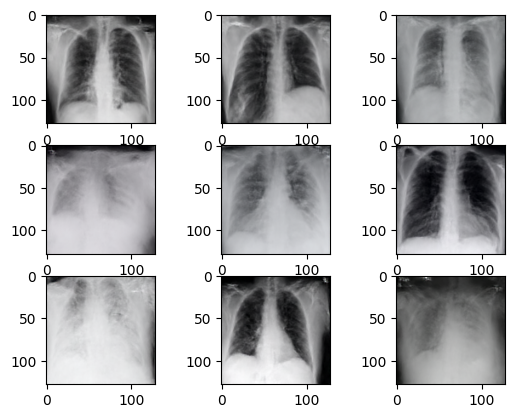

In [19]:
sample_image_generation(model, noise_scheduler, NUM_GENERATE_IMAGES, RANDOM_SEED, NUM_TIMESTEPS)

In [ ]:
# # Define your save path
# save_path = r"/content/drive/MyDrive/4. BGSU/1.2 PhD_Courses/3. 7200_Machin Learning/Final_project/CS7200_SP2024_Project_G01/Notebooks/DDPM-Pytorch/save_model/checkpoint.pth"

# # Collect the states
# checkpoint = {
#     "model_state_dict": accelerator.unwrap_model(model).state_dict(),
#     "optimizer_state_dict": optimizer.state_dict(),
#     "scheduler_state_dict": lr_scheduler.state_dict(),
#     "accelerator_state_dict": accelerator.state_dict()
# }

# # Save checkpoint
# torch.save(checkpoint, save_path)

In [20]:
checkpoint = {
    "model_state_dict": model.state_dict(),  # Assuming model is the actual model or accelerator.unwrap_model(model)
    "optimizer_state_dict": optimizer.state_dict(),
    "scheduler_state_dict": lr_scheduler.state_dict(),
}

# Define your save path
save_path = "/content/drive/MyDrive/4. BGSU/1.2 PhD_Courses/3. 7200_Machin Learning/Final_project/CS7200_SP2024_Project_G01/Notebooks/DDPM-Pytorch//save_model/checkpoint.pth"

# Save checkpoint
torch.save(checkpoint, save_path)


In [13]:
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=len(train_dataloader)*NUM_EPOCHS
)

accelerator = Accelerator(
    mixed_precision=MIXED_PRECISION,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS
)

model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(model, optimizer, train_dataloader, lr_scheduler)

In [14]:
# Load the checkpoint
save_path = "/content/drive/MyDrive/4. BGSU/1.2 PhD_Courses/3. 7200_Machin Learning/Final_project/CS7200_SP2024_Project_G01/Notebooks/DDPM-Pytorch//save_model/checkpoint.pth"

checkpoint = torch.load(save_path)

# Load states into the model, optimizer, and scheduler
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
lr_scheduler.load_state_dict(checkpoint["scheduler_state_dict"])

# If you're resuming training and need to prepare these components with Accelerator again
model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(model, optimizer, train_dataloader, lr_scheduler)


  0%|          | 0/1000 [00:00<?, ?it/s]

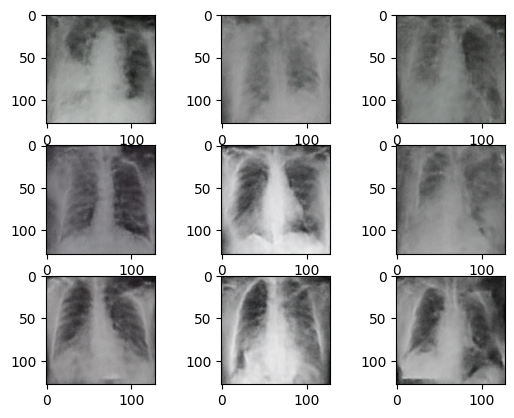

In [23]:
sample_image_generation(model, noise_scheduler, NUM_GENERATE_IMAGES, RANDOM_SEED, NUM_TIMESTEPS)

In [15]:
def sample_image_generation2(model, noise_scheduler, num_generate_images, random_seed, num_timesteps, save_dir):
    pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

    images = pipeline(
        batch_size=num_generate_images,
        generator=torch.manual_seed(random_seed),
        num_inference_steps=num_timesteps
    ).images

    for i, image in enumerate(images):
        if not os.path.exists(save_dir):
            # If the directory does not exist, create it
            os.makedirs(save_dir)
        save_path = os.path.join(save_dir, f"generated_image_{i+1}.png")
        if not isinstance(image, Image.Image):
            # Convert tensor image to PIL Image only if necessary
            pil_image = transforms.ToPILImage()(image)
        else:
            # If it's already a PIL image, no need to convert
            pil_image = image
        pil_image.save(save_path)

In [16]:
NUM_GENERATE_IMAGES = 50
save_dir = "/content/drive/MyDrive/4. BGSU/1.2 PhD_Courses/3. 7200_Machin Learning/Final_project/CS7200_SP2024_Project_G01/Notebooks/DDPM-Pytorch/save_model/save_images_final"
sample_image_generation2(model, noise_scheduler, NUM_GENERATE_IMAGES, RANDOM_SEED, NUM_TIMESTEPS, save_dir)

  0%|          | 0/2000 [00:00<?, ?it/s]

# Archive

In [ ]:

sample_image = dataset[0]["images"].unsqueeze(0).to(device)
# print("Input shape", sample_image.shape)
# print("Output shape", model(sample_image, timestep=0).sample.shape)



Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).cpu().numpy()[0])

noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)
# print(loss)
path = "/content/drive/MyDrive/4. BGSU/1.2 PhD_Courses/3. 7200_Machin Learning/Final_project/CS7200_SP2024_Project_G01/Notebooks/DDPM-Pytorch/save_model"
save_dir = f"{path}/save_images_training"
def sample_image_generation(model, noise_scheduler, num_generate_images, random_seed, num_timesteps, save_dir):
    pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

    images = pipeline(
        batch_size=num_generate_images,
        generator=torch.manual_seed(random_seed),
        num_inference_steps=num_timesteps
    ).images

    # Ensure save_dir exists

    os.makedirs(save_dir, exist_ok=True)

    # # Convert PyTorch tensors to PIL images and save
    # for i, img_tensor in enumerate(images):
    #     # Assuming images are in the tensor format (C, H, W) and pixel values are normalized
    #     img = transforms.ToPILImage()(img_tensor).convert("RGB")
    #     file_path = os.path.join(save_dir, f"generated_image_{i+1}.png")
    #     img.save(file_path)
    #     print(f"Image {i+1} saved to {file_path}")

    # Loop through the generated images and save them
    for i, image in enumerate(images):
        # Convert the tensor image to a PIL Image
        image_np = image.squeeze().numpy()  # Squeeze is used to remove channel dim if it's 1; for grayscale images
        img = Image.fromarray(np.uint8(image_np * 255), 'L')  # Convert to uint8 and create PIL Image in 'L' mode for grayscale

        # Save the image
        img.save(f"{save_dir}/image_{i+1}.png")



optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=len(train_dataloader)*NUM_EPOCHS
)

accelerator = Accelerator(
    mixed_precision=MIXED_PRECISION,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS
)

model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(model, optimizer, train_dataloader, lr_scheduler)

start = timeit.default_timer()
for epoch in tqdm(range(NUM_EPOCHS), position=0, leave=True):
    model.train()
    train_running_loss = 0
    for idx, batch in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        clean_images = batch["images"].to(device)
        noise = torch.randn(clean_images.shape).to(device)
        last_batch_size = len(clean_images)

        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (last_batch_size,)).to(device)
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        with accelerator.accumulate(model):
            noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
            loss = F.mse_loss(noise_pred, noise)
            accelerator.backward(loss)

            accelerator.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

        train_running_loss += loss.item()
    train_loss = train_running_loss / (idx+1)

    train_learning_rate = lr_scheduler.get_last_lr()[0]
    print("-"*30)
    print(f"Train Loss EPOCH: {epoch+1}: {train_loss:.4f}")
    print(f"Train Learning Rate EPOCH: {epoch+1}: {train_learning_rate}")
    if epoch%10 == 0:
        sample_image_generation(model, noise_scheduler, NUM_GENERATE_IMAGES, RANDOM_SEED, NUM_TIMESTEPS, save_dir)
    print("-"*30)

stop = timeit.default_timer()
print(f"Training Time: {stop-start:.2f}s")


save_dir = f"{path}/save_images_final"
NUM_GENERATE_IMAGES = 50
sample_image_generation(model, noise_scheduler, NUM_GENERATE_IMAGES, RANDOM_SEED, NUM_TIMESTEPS, save_dir)

# Define your save path
save_path = f"{path}/checkpoint.pth"

# Collect the states
checkpoint = {
    "model_state_dict": accelerator.unwrap_model(model).state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "scheduler_state_dict": lr_scheduler.state_dict(),
    "accelerator_state_dict": accelerator.state_dict()
}

# Save checkpoint
torch.save(checkpoint, save_path)

# Load the checkpoint
checkpoint = torch.load(save_path)

# Load states into the model, optimizer, and scheduler
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
lr_scheduler.load_state_dict(checkpoint["scheduler_state_dict"])

# Prepare them with Accelerator again if necessary
model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(model, optimizer, train_dataloader, lr_scheduler)

# Optionally, load accelerator state
accelerator.load_state_dict(checkpoint["accelerator_state_dict"])


100%|██████████| 7/7 [00:04<00:00,  1.44it/s]

------------------------------
Train Loss EPOCH: 1: 1.1566
Train Learning Rate EPOCH: 1: 1.4000000000000001e-06


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/50 [02:38<?, ?it/s]


AttributeError: squeeze